In [1]:
#always
import os
#global variables

strain='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/'
results_file = '/n/groups/datta/Dana'
pc_scores='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220323_long_ont_model_robust_s1.p'
'''
strain='/n/groups/datta/Dana/new_figs/'
pc_scores='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_ont_model_robust_s1.p'
'''
n_training_mice=.93 #percent of mice to be used for training
use_post_hoc_sort=False
seed=28
compnumc=3
n_training_mice=6
n_syllables_to_plot=91
max_syllable=91
gep_color_mat=['limegreen', 'peru', 'silver']

'''
data_loc=strain+'_data'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

os.chdir(data_loc)
'''

"\ndata_loc=strain+'_data'\ntry:\n    os.mkdir(data_loc)\nexcept FileExistsError:\n    # directory already exists\n    pass\n\nos.chdir(data_loc)\n"

In [2]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
seqmatcolor='Purples_r'
divmatcolor=cmr.watermelon_r
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

In [3]:
#moseq imports
from moseq2_viz.model.util import parse_model_results
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.dist import get_behavioral_distance

# Behavioral Distance Dependencies
from scipy.cluster.hierarchy import linkage, dendrogram

# Transition Matrices Compute/Graphing Dependencies
from moseq2_viz.model.util import parse_model_results, relabel_by_usage
from moseq2_viz.model.trans_graph import get_trans_graph_groups, get_group_trans_mats

# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# FUNCTIONS
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [4]:
def subset_label_counts(counts,uuids_conditions,condition):
    m=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(counts[i])
    return np.array(m)

In [5]:
def subset_labels(labels,uuids_conditions,condition):
    m=[]
    u=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
    return np.array(m),u


In [6]:
def labels_and_scalars(labels,results_file,uuids_conditions,a_scalar='velocity_2d_mm',condition='12'):
    ljm,bhj=get_subsetted_scalars(a_scalar,condition,uuids_conditions,results_file)
    gerf,onon=subset_labels(labels,uuids_conditions,condition)
    da_real=[]
    for n in onon:
        #print(bhj.index(n))
        da_real.append(bhj.index(n))
    return gerf, np.array(ljm)[da_real], onon

In [7]:
def normalize(a):
    norm_a=a/(np.max(a)-np.min(a))
    norm_a=a/(np.max(a)-np.min(a)) 
    return(norm_a)


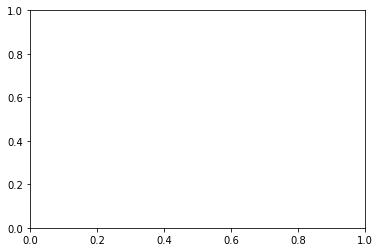

In [8]:
fig,ax=plt.subplots()
def plot_size_corr(l,s,syllable=0,color='black',ax=ax):
    hjkjkg=[]
    gbfgbfdfd=[]
    
    for i in range(len(l)):
        if sum(l[i]==syllable) != 0:
            try:

                hjkjkg.append(  sum(l[i]==syllable) /  sum(l[i]>-4)   )
                gbfgbfdfd.append(np.nanmedian(s[i]))
            except:
                pass
    
    #x=weight y=usage
    ax.scatter(gbfgbfdfd,hjkjkg,color=color) 
    idxpp = np.isfinite(hjkjkg) & np.isfinite(gbfgbfdfd)
    
    z = np.polyfit(gbfgbfdfd,hjkjkg,  1)
    p = np.poly1d(z)
    ax.plot(gbfgbfdfd,p(gbfgbfdfd),color=color,linestyle='--')

In [9]:
def get_subsetted_scalars(a_scalar,condition,uuids_conditions,directory):
    
    #accessing scalar data from results files
    here=os.getcwd()
    os.chdir(directory) #if the directory contains the session folders directly then you dont need the */ in front of session in the glob.glob below

    result_h5_files=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.h5"):
        result_h5_files.append(file)
        #print(file)


    result_h5_uuid=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.yaml"):
        with open(file) as f:
            y=yaml.load(f)
            ido=y['uuid']
            result_h5_uuid.append(ido)
            #print(id)
        f.close()
    f.close()


    scalar=[]
    associated_uuid=[]
    i=0
    j=0
    for u in result_h5_uuid:
        for uc in uuids_conditions:
            if u == uc[0]:
                if str(uc[1])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[17:19] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)
            j=j+1
        i=i+1
        j=0
    os.chdir(here)
    return scalar,associated_uuid

In [10]:
def pca_on_np_array(nparray):
    '''rows are members (mice), columns are variables (syllables)'''
    nparray -= np.mean(nparray, axis = 0)  
    #calculate covariance matrix
    cov = np.cov(nparray, rowvar = False)
    #get eigenvectors and eigenvalues
    evals , evecs = LA.eigh(cov)

    #formatting and SORT by eigenvalues (aka sort by how much variance each eigen vector explains)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    #this is your data represented as PCS 
    nparray_represented_as_pcs = np.dot(nparray, evecs)
    
    return nparray_represented_as_pcs,evecs,evals

In [11]:
def trans_mat_diff(trans_mats,tm1,tm2):

    #normalize both input matrices
    tma=trans_mats[tm1]/(np.max(trans_mats[tm1])-np.min(trans_mats[tm1]))
    tmb=trans_mats[tm2]/(np.max(trans_mats[tm2])-np.min(trans_mats[tm2]))

    tmdiff=np.subtract(tmb,tma)
    
    return tmdiff

In [12]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [13]:
def counttrigram(ooga,cutoff):
    n=3
    gram_mat=np.zeros(([100]*n))
    i=ooga[2]
    j=ooga[3]
    k=ooga[4]
    for c in range(3,len(ooga)-2):
        if ooga[c] != -5 and ooga[c+1] != -5 and ooga[c+2] != -5:
            if ooga[c] < cutoff and ooga[c+1] < cutoff and ooga[c+2] < cutoff:  
                i=ooga[c]
                j=ooga[c+1]
                k=ooga[c+2]
                gram_mat[i][j][k]=gram_mat[i][j][k]+1

    return gram_mat
    

In [14]:
def plot_a_syllable(s,s_description='',legend=False):

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color_mat[0], lw=4),
                    Line2D([0], [0], color=color_mat[1], lw=4),
                    Line2D([0], [0], color=color_mat[2], lw=4),
                    Line2D([0], [0], color=color_mat[3], lw=4),
                    Line2D([0], [0], color=color_mat[4], lw=4),
                    Line2D([0], [0], color=color_mat[5], lw=4),
                    Line2D([0], [0], color=color_mat[6], lw=4),
                    Line2D([0], [0], color=color_mat[7], lw=4)]


    fig, ax = plt.subplots()
    fig.set_size_inches(3,8)
    plt.title(s_description,fontsize=17)
    a=sns.pointplot(data=frequencies[0][:,s],ax=ax,label=age_labels[0],linestyles='',markersize=5,color=color_mat[0])
    b=sns.pointplot(data=frequencies[1][:,s],ax=ax,label=age_labels[1],linestyles='',markersize=5,color=color_mat[1])
    c=sns.pointplot(data=frequencies[2][:,s],ax=ax,label=age_labels[2],linestyles='',markersize=5,color=color_mat[2])
    d=sns.pointplot(data=frequencies[3][:,s],ax=ax,label=age_labels[3],linestyles='',markersize=5,color=color_mat[3])
    e=sns.pointplot(data=frequencies[4][:,s],ax=ax,label=age_labels[4],linestyles='',markersize=5,color=color_mat[4])
    f=sns.pointplot(data=frequencies[5][:,s],ax=ax,label=age_labels[5],linestyles='',markersize=5,color=color_mat[5])
    g=sns.pointplot(data=frequencies[6][:,s],ax=ax,label=age_labels[6],linestyles='',markersize=5,color=color_mat[6])
    h=sns.pointplot(data=frequencies[7][:,s],ax=ax,label=age_labels[7],linestyles='',markersize=5,color=color_mat[7])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticks([])
    #ax.set_xlim([-1,(max_syllable-.5)])
    if legend:
        plt.legend(handles=custom_lines,labels=cohort_labels,bbox_to_anchor=(1.05, 1),loc='upper left')

    plt.xlabel('Syllable_' + str(s),fontsize=17)
    plt.ylabel('Frequency',fontsize=17)
    fig.patch.set_facecolor('white')
    plt.show()

In [15]:
def get_best_nmf(datamat,uptoncomps=10,restarts=10,save=False,title='nmf_performance',howtocalc='use_sum'):
    from sklearn.decomposition import NMF
    import scipy.cluster.hierarchy as hc
    from numpy import inf
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    Hs=[]
    for c in range(2,uptoncomps):
        Hn=[]
        for r in range(restarts):    
            model = NMF(n_components=c, init='random', random_state=r)
            W = model.fit_transform(datamat)
            H = model.components_
            Hn.append(H)
        Hs.append(Hn)
        
    fig, ax = plt.subplots(1,uptoncomps-2) 
    fig.set_size_inches((uptoncomps-2)*4,(uptoncomps-2))
    
    
    for hhh in range(len(Hs)):
        
        wrf=np.zeros((restarts,restarts))
        for i in range(len(Hs[0])):
            for j in range(restarts):
                for k in range(restarts):
                    if howtocalc=='use_sum':
                        corrrr=np.corrcoef(x=np.sum(Hs[hhh][j],axis=0),y=np.sum(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_var':
                        corrrr=np.corrcoef(x=np.var(Hs[hhh][j],axis=0),y=np.var(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_entropy':
                        try:
                            corrrr=scipy.stats.entropy(pk=Hs[hhh][j],qk=Hs[hhh][k],axis=0)
                            corrrr[corrrr == inf] = 1
                        except:
                            corrrr=0
                    #print(np.mean(corrrr))
                    if howtocalc != 'use_entropy':
                        wrf[j][k]=corrrr[0,1]
                    if howtocalc == 'use_entropy':
                        wrf[j][k]=np.nanmedian(corrrr)

        ax[hhh].set_xticks([]) 
        ax[hhh].set_yticks([])    
        #ax[hhh].imshow(wrf,cmap='gray',vmin=0, vmax=1)
        
        #sns.clustermap(wrf,cmap='gray',vmin=0, vmax=1,ax=ax[hhh])

        
        d=pd.DataFrame(wrf)
        link = hc.linkage(d.values, method='centroid')
        o1 = hc.leaves_list(link)
        mat = d.iloc[o1,:]
        mat = mat.iloc[:, o1[::-1]]
        ax[hhh].imshow(mat,cmap='gist_earth',vmin=0, vmax=1)
        
        kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=28)
        kmeans.fit(wrf)
        score = silhouette_score(wrf, kmeans.labels_)
        
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(np.mean(wrf))[0:5] + ')')#use entopy of values to determine best "cluster"
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(scipy.stats.entropy(wrf))[0:5] + ')')
        ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(kmeans.inertia_)[0:5] + ')') #use kmeans inertia
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(score)[0:5] + ')') #use kmeans silhoutte scores
        
        
    fraction = .04  # .05
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = ax[hhh].figure.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap='gist_earth'),
    ax=ax[hhh], pad=0, fraction=fraction)
    fig.patch.set_facecolor('white')

    plt.show()
    
    if save:
        fig.savefig((title)+".pdf",  bbox_inches='tight')
        fig.savefig((title)+".png",  bbox_inches='tight')
        
    return Hs

In [16]:
def return_confusion(predictions):
    cnf_mat=np.zeros((len(predictions),len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            cnf_mat[i,j]=np.count_nonzero(predictions[i]==j) / len(predictions[i])
    return cnf_mat
    

In [17]:
#can chance based on number of pcs
def contribution_of_each_syllable_to_distance(nparray1,nparray2,npcs=10):
    pcs,eigenvectors,eigenvalues=pca_on_np_array(np.concatenate((nparray1,nparray2),axis=0))

    n_mice1=len(nparray1)
    n_mice2=len(nparray2)
    n_syllables=len(nparray1[0])

    #get the mean pc scores for each group
    group1_mean_pcs=np.mean(pcs[0:(n_mice1-1)],axis=0)
    group2_mean_pcs=np.mean(pcs[n_mice1:((n_mice1+n_mice2)-1)],axis=0)
    #calculate the absolute pairwise difference between pcs and divide by the sum 
    difference=np.abs(np.subtract(group1_mean_pcs,group2_mean_pcs))
    square_difference=np.square(difference)
    sum_of_square_difference=sum(square_difference)
    weighted_difference=square_difference/sum_of_square_difference

    #calculate how much each syllable contributes to each eigenvector and ultimately the distance between groups
    contribution_of_each_syllable=np.zeros((n_syllables,n_syllables),dtype=float)
    for i in range(n_syllables):
        pc_i_contribution_to_all_syllables=weighted_difference[i]*np.square(eigenvectors[:,i])*((eigenvalues[i]**2/sum(eigenvalues**2)))
        contribution_of_each_syllable[i,:]=pc_i_contribution_to_all_syllables
    
    contribution_of_each_syllable=sum(contribution_of_each_syllable[0:npcs])/sum(sum(contribution_of_each_syllable)[0:npcs])
    
    return contribution_of_each_syllable

In [18]:
def plot_scalars(results_file,scalar_of_interest,ylim=False):
    ''' angle
        area_mm
        area_px
        centroid_x_mm
        centroid_x_px
        centroid_y_mm
        centroid_y_px
        height_ave_mm
        length_mm
        length_px
        velocity_2d_mm
        velocity_2d_px
        velocity_3d_mm
        velocity_3d_px
        velocity_theta
        width_mm
        width_px'''
    vel2d_03w,uuid_03w=get_subsetted_scalars(scalar_of_interest,'03',uuids_conditions,results_file)
    vel2d_05w,uuid_05w=get_subsetted_scalars(scalar_of_interest,'05',uuids_conditions,results_file)
    vel2d_07w,uuid_07w=get_subsetted_scalars(scalar_of_interest,'07',uuids_conditions,results_file)
    vel2d_09w,uuid_09w=get_subsetted_scalars(scalar_of_interest,'90',uuids_conditions,results_file)
    vel2d_03m,uuid_03m=get_subsetted_scalars(scalar_of_interest,'3m',uuids_conditions,results_file)
    vel2d_06m,uuid_06m=get_subsetted_scalars(scalar_of_interest,'6m',uuids_conditions,results_file)
    vel2d_12m,uuid_12m=get_subsetted_scalars(scalar_of_interest,'12',uuids_conditions,results_file)
    vel2d_18m,uuid_18m=get_subsetted_scalars(scalar_of_interest,'18',uuids_conditions,results_file)

    a_scalar_means_03w=[]
    for i in range(len(vel2d_03w)):
        a_scalar_means_03w.append(np.nanmean(vel2d_03w[i]))

    a_scalar_means_05w=[]
    for i in range(len(vel2d_05w)):
        a_scalar_means_05w.append(np.nanmean(vel2d_05w[i]))

    a_scalar_means_07w=[]
    for i in range(len(vel2d_07w)):
        a_scalar_means_07w.append(np.nanmean(vel2d_07w[i]))

    a_scalar_means_09w=[]
    for i in range(len(vel2d_09w)):
        a_scalar_means_09w.append(np.nanmean(vel2d_09w[i]))

    a_scalar_means_03m=[]
    for i in range(len(vel2d_03m)):
        a_scalar_means_03m.append(np.nanmean(vel2d_03m[i]))

    a_scalar_means_06m=[]
    for i in range(len(vel2d_06m)):
        a_scalar_means_06m.append(np.nanmean(vel2d_06m[i]))

    a_scalar_means_12m=[]
    for i in range(len(vel2d_12m)):
        a_scalar_means_12m.append(np.nanmean(vel2d_12m[i]))

    a_scalar_means_18m=[]
    for i in range(len(vel2d_18m)):
        a_scalar_means_18m.append(np.nanmean(vel2d_18m[i]))

    a_scalar_means_data=[a_scalar_means_03w,a_scalar_means_05w,a_scalar_means_07w,a_scalar_means_09w,
                         a_scalar_means_03m,a_scalar_means_06m,a_scalar_means_12m,a_scalar_means_18m]

    fig ,ax=plt.subplots()
    fig.set_size_inches(16,4)
    sns.boxplot(data=a_scalar_means_data)
    plt.xticks(plt.xticks()[0], cohort_labels)
    if ylim:
        ax.set_ylim(ylim)
    plt.title(strain + ' ' + scalar_of_interest)
    plt.show()
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.pdf', bbox_inches='tight')
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.png', bbox_inches='tight')

In [19]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [20]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def int_to_datetime(date):
    date=str(date)
    a=date[0:4]
    b=date[4:6]
    c=date[6:8]
    return datetime.date(int(a), int(b), int(c))

# LOAD DATA AND QUALITY CONTROL


In [21]:
#if max syllables in the original learn model is less than 100, then you cannot sort labels by usage here
model_results = parse_model_results(model_file,sort_labels_by_usage=True) 

index, sorted_index = parse_index(index_file)

In [22]:
#list(model_data) #get the syllable labels and the uuids (keys) from the model file
model_labels=model_results['labels']
model_keys=model_results['keys']
index_keys_and_fields=[]

#get the uuids (keys) and the user-entered metadata from the index file as well as the date of the session
for n in sorted_index['files']:
    #find the session numbers
    index_of_str_session=sorted_index['files'][n]['path'][0].index('session')
    #find the experiment (all experiment id start with the str "rec" (short for reconstructed))
    index_of_str_rec=sorted_index['files'][n]['path'][0].index('rec')
    index_keys_and_fields.append([n,
                             sorted_index['files'][n]['metadata']['SubjectName'],
                             sorted_index['files'][n]['metadata']['SessionName'],
                             sorted_index['files'][n]['path'][0][index_of_str_session+8:index_of_str_session+16],
                             sorted_index['files'][n]['path'][0][index_of_str_rec:index_of_str_rec+12]])
    
'''with open(strain + 'conditions_.pkl', 'wb') as f:
    pickle.dump(uuids_conditions, f)
    f.close()'''

"with open(strain + 'conditions_.pkl', 'wb') as f:\n    pickle.dump(uuids_conditions, f)\n    f.close()"

In [23]:
individual_longtogeny_males=[]
individual_longtogeny_females=[]
individual_ontogeny_males=[]

ikf1=np.array(index_keys_and_fields)[:,1]
ikf2=np.array(index_keys_and_fields)[:,2]
ikf4=np.array(index_keys_and_fields)[:,4]

for i in range(len(ikf1)):
    if 'rec_lon_male' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]) and ('5' not in ikf1[i]):
            individual_longtogeny_males.append(ikf1[i][0:5])
    if 'rec_lon_fema' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]):
            individual_longtogeny_females.append(ikf1[i][0:5])
    if 'rec_ont_male' in ikf4[i]:
        individual_ontogeny_males.append(ikf2[i][0:20] + '_' + ikf1[i][0:20])
            
unique_individual_longtogeny_males=unique(individual_longtogeny_males)
unique_individual_longtogeny_males.sort()
unique_individual_longtogeny_females=unique(individual_longtogeny_females)
unique_individual_longtogeny_females.sort()
unique_individual_ontogeny_males=unique(individual_ontogeny_males)
unique_individual_ontogeny_males.sort()

In [24]:
#create different index_key_field variables for the three experiments

rec_lon_male_index_keys_and_fields=[]
rec_lon_fema_index_keys_and_fields=[]
rec_ont_male_index_keys_and_fields=[]

for n in index_keys_and_fields:
    if 'rec_lon_male' in n[4]:
        rec_lon_male_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_lon_fema' in n[4]:
        rec_lon_fema_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_ont_male' in n[4]:
        rec_ont_male_index_keys_and_fields.append(n)

In [25]:
#remove aging and nor and default from male/female lontogeny sessions

#male
corruption=True
while corruption:
    for n in range(len(rec_lon_male_index_keys_and_fields)):
        if ('a' in rec_lon_male_index_keys_and_fields[n][1]) or ('d' in rec_lon_male_index_keys_and_fields[n][1]) or ('n' in rec_lon_male_index_keys_and_fields[n][1]) or ('a' in rec_lon_male_index_keys_and_fields[n][2]) or ('d' in rec_lon_male_index_keys_and_fields[n][2]) or ('n' in rec_lon_male_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_male_index_keys_and_fields.pop(n)
            break
        corruption=False
    #print('males purged')

        #females
corruption=True
while corruption:
    for n in range(len(rec_lon_fema_index_keys_and_fields)):
        if ('a' in rec_lon_fema_index_keys_and_fields[n][1]) or ('d' in rec_lon_fema_index_keys_and_fields[n][1]) or ('n' in rec_lon_fema_index_keys_and_fields[n][1]) or ('a' in rec_lon_fema_index_keys_and_fields[n][2]) or ('d' in rec_lon_fema_index_keys_and_fields[n][2]) or ('n' in rec_lon_fema_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_fema_index_keys_and_fields.pop(n)
            break
        corruption=False
    #print('females purged')

In [26]:
male_dates=unique(np.array(rec_lon_male_index_keys_and_fields)[:,3])
male_dates.sort()

female_dates=unique(np.array(rec_lon_fema_index_keys_and_fields)[:,3])
female_dates.sort()

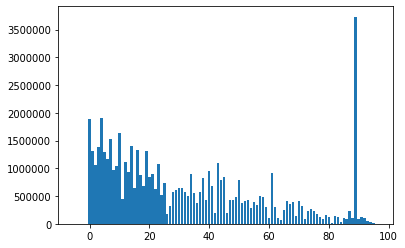

In [27]:
#show the syllable length across all sessions. unusually long ones are usually noisy syllables 
data_concatenated=np.hstack(copy.copy(model_labels))
c = Counter(data_concatenated)
plt.bar(c.keys(), c.values())
plt.show()

In [28]:
#sort longtogeny labels by the date (can also sort the individuals later)

#males longtogeny

male_sorted_labels=[]
male_linear_sorted_fields=[]
male_linear_sorted_labels=[]
for d in male_dates:
    labels_for_d_date=[]
    for k in rec_lon_male_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                male_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3]))
                male_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    male_sorted_labels.append(labels_for_d_date)

#females longtogeny

female_sorted_labels=[]
female_linear_sorted_fields=[]
female_linear_sorted_labels=[]
for d in female_dates:
    labels_for_d_date=[]
    for k in rec_lon_fema_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                female_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3]))
                female_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    female_sorted_labels.append(labels_for_d_date)

In [29]:
# get noise syllable
ms=max(c.values())
nos_ind = list(c.values()).index(ms)
nos_syl=list(c.keys())[nos_ind]

In [30]:
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24

male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))

In [31]:
#sort ontogeny labels by group 
#ontogeny has 8 groups
ontogeny_groups=['3_weeks','5_weeks','7_weeks','9_weeks','3_months','6_months','12_months','18_months']
#they can be identified by unique strings in the unique_individual_ontogeny_males list
#these unique strings are:
ontogeny_group_string_identifiers=['y_03','y_05','y_07','y_09','3m_o','6m_o','_12m_','_18m_']

ontogeny_sorted_labels=[]
ontogeny_linear_sorted_fields=[]
ontogeny_linear_sorted_labels=[]

for g in ontogeny_group_string_identifiers:
    labels_for_group_d=[]
    for k in rec_ont_male_index_keys_and_fields:
        string_to_cross_reference=k[2][0:20] + '_' + k[1][0:20]
        if g in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    ontogeny_sorted_labels.append(labels_for_group_d)            

In [32]:
#sort ontogeny labels by group 
#ontogeny has 8 groups
ontogeny_groups=['3_weeks','5_weeks','7_weeks','9_weeks','3_months','6_months','12_months','18_months']
#they can be identified by unique strings in the unique_individual_ontogeny_males list
#these unique strings are:
ontogeny_group_string_identifiers=['y_03','y_05','y_07','y_09','3m_o','6m_o','_12m_','_18m_']


ontogeny_sorted_labels=[]
ontogeny_linear_sorted_fields=[]
ontogeny_linear_sorted_labels=[]


for g in ontogeny_group_string_identifiers:
    labels_for_group_d=[]
    for k in rec_ont_male_index_keys_and_fields:
        string_to_cross_reference=k[2][0:20] + '_' + k[1][0:20]
        #print(string_to_cross_reference)
        if g in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])

            except:
                pass
        #add missing ontogeny data d    
        if g == 'y_03' and '_3wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
                print('3 weeks straggers worked')
            except:
                pass
        if g == 'y_05' and '_5wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_07' and '_7wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_09' and '_9wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append(ontogeny_groups[ontogeny_group_string_identifiers.index(g)])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
            
    ontogeny_sorted_labels.append(labels_for_group_d)   

3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked
3 weeks straggers worked


In [33]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
male_all_label_frequency_counts=[]
for sl in male_sorted_labels[:]:
    male_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            male_label_frequency_counts[i][syllable[j]]=count[j]
        male_label_frequency_counts[i][-5]=0
    male_all_label_frequency_counts.append(male_label_frequency_counts)
male_linear_sorted_frequencies=list(np.vstack(male_all_label_frequency_counts))

print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))

762
762
762


In [34]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
female_all_label_frequency_counts=[]
for sl in female_sorted_labels[:]:
    female_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            female_label_frequency_counts[i][syllable[j]]=count[j]
        female_label_frequency_counts[i][-5]=0
    female_all_label_frequency_counts.append(female_label_frequency_counts)
female_linear_sorted_frequencies=list(np.vstack(female_all_label_frequency_counts))

print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))

523
523
523


In [35]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
ontogeny_all_label_frequency_counts=[]
for sl in ontogeny_sorted_labels[:]:
    ontogeny_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        m=sl[i][:]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            ontogeny_label_frequency_counts[i][syllable[j]]=count[j]
        ontogeny_label_frequency_counts[i][-5]=0
    ontogeny_all_label_frequency_counts.append(ontogeny_label_frequency_counts)
ontogeny_linear_sorted_frequencies=list(np.vstack(ontogeny_all_label_frequency_counts))

print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))

185
185
185


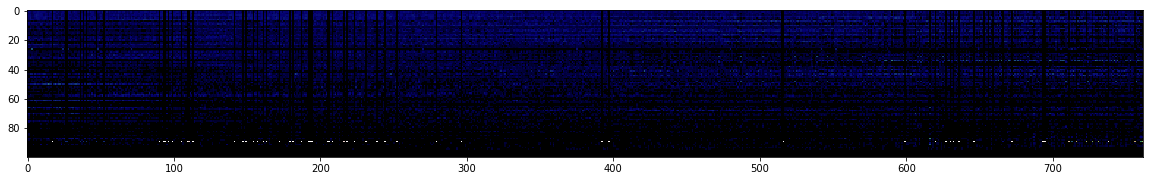

In [36]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

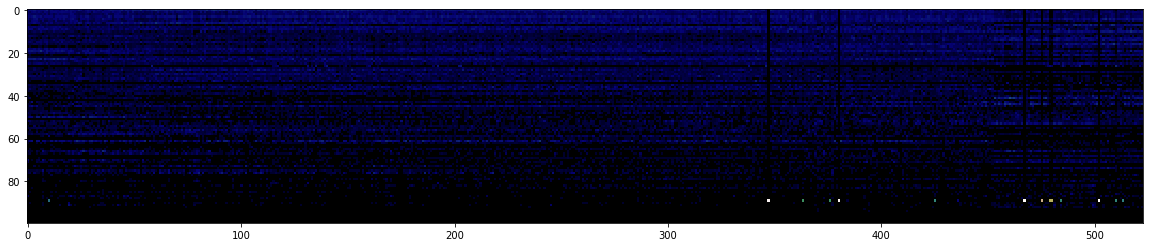

In [37]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

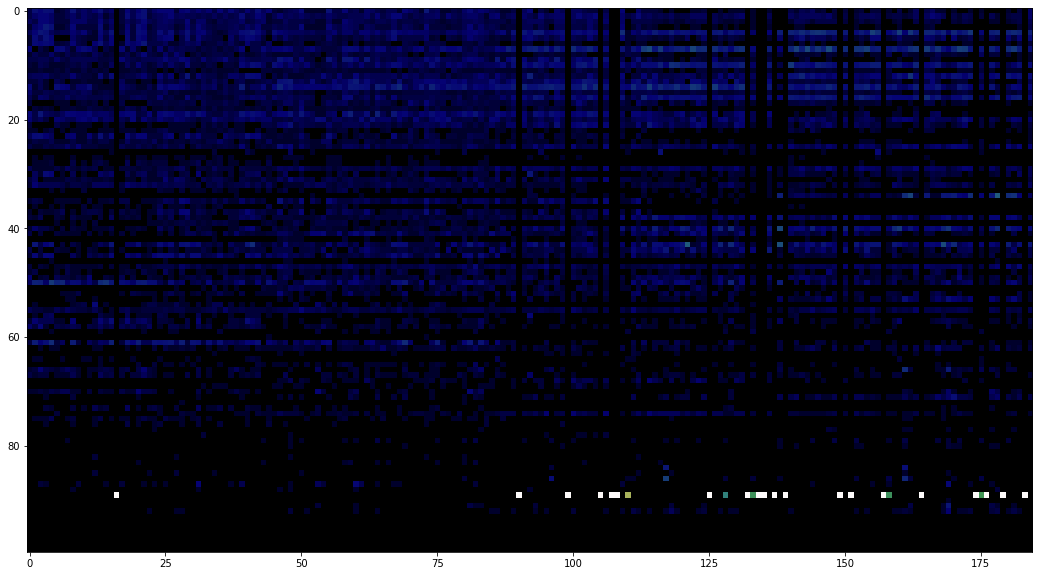

In [38]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [39]:
#count the number of labels in each of the sessions
male_mice_per_day_pre_pop=[]
for a in male_all_label_frequency_counts:
    male_mice_per_day_pre_pop.append(len(a))
    
female_mice_per_day_pre_pop=[]
for a in female_all_label_frequency_counts:
    female_mice_per_day_pre_pop.append(len(a))
    
ontogeny_mice_per_day_pre_pop=[]
for a in ontogeny_all_label_frequency_counts:
    ontogeny_mice_per_day_pre_pop.append(len(a))

In [40]:
#sessions that only expressed less than 1000 syllables and median syllable is < 10 should be purged

#male longtogeny
corruption=True
while corruption:
    for n in range(len(male_linear_sorted_frequencies)):
        if sum(male_linear_sorted_frequencies[n])<=1000 or median(male_linear_sorted_frequencies[n])<=10:
            print(male_linear_sorted_fields[n])
            corruption=True
            male_linear_sorted_labels.pop(n)
            male_linear_sorted_frequencies.pop(n)
            male_linear_sorted_fields.pop(n)
            break
        corruption=False

#female longtogeny
corruption=True
while corruption:
    for n in range(len(female_linear_sorted_frequencies)):
        if sum(female_linear_sorted_frequencies[n])<=1000 or median(female_linear_sorted_frequencies[n])<=10:
            print(female_linear_sorted_fields[n])
            corruption=True
            female_linear_sorted_labels.pop(n)
            female_linear_sorted_frequencies.pop(n)
            female_linear_sorted_fields.pop(n)
            break
        corruption=False

#male ontogeny
corruption=True
while corruption:
    for n in range(len(ontogeny_linear_sorted_frequencies)):
        if sum(ontogeny_linear_sorted_frequencies[n])<=1000 or median(ontogeny_linear_sorted_frequencies[n])<=10:
            #print(ontogeny_linear_sorted_fields[n])
            corruption=True
            ontogeny_linear_sorted_labels.pop(n)
            ontogeny_linear_sorted_frequencies.pop(n)
            ontogeny_linear_sorted_fields.pop(n)
            break
        corruption=False

('03', '03', '20210331')
('04', '03', '20210401')
('02', '03', '20210401')
('03', '03', '20210402')
('01', '03', '20210402')
('04', '03', '20210402')
('01', '03', '20210403')
('03', '03', '20210403')
('04', '03', '20210406')
('04', '03', '20210407')
('01', '03', '20210407')
('02', '03', '20210407')
('03', '03', '20210407')
('03', '03', '20210408')
('02', '03', '20210408')
('04', '03', '20210408')
('01', '03', '20210408')
('02', '03', '20210420')
('04', '03', '20210420')
('01', '03', '20210420')
('03', '03', '20210420')
('01', '03', '20210423')
('02', '03', '20210423')
('03', '03', '20210423')
('04', '03', '20210426')
('01', '03', '20210426')
('03', '03', '20210426')
('04', '03', '20210503')
('01', '03', '20210503')
('02', '03', '20210503')
('03', '03', '20210503')
('01', '03', '20210506')
('04', '03', '20210506')
('03', '03', '20210506')
('01', '03', '20210510')
('03', '03', '20210510')
('02', '03', '20210510')
('04', '03', '20210510')
('03', '03', '20210514')
('02', '03', '20210514')


In [41]:
# turn noise syllable count to 0
for ind,mouse in enumerate(male_linear_sorted_frequencies):
    male_linear_sorted_frequencies[ind][nos_syl]=0

for ind,mouse in enumerate(female_linear_sorted_frequencies):
    female_linear_sorted_frequencies[ind][nos_syl]=0

for ind,mouse in enumerate(ontogeny_linear_sorted_frequencies):
    ontogeny_linear_sorted_frequencies[ind][nos_syl]=0

In [42]:
#make a new CLEAN all_label_frequency_counts variable (male longtogeny)
ttt=0
tttt=0
male_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=male_linear_sorted_fields[0][2]
for n in range(len(male_linear_sorted_fields)):
    dates_used.append(male_linear_sorted_fields[n][2])
    if male_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(male_linear_sorted_frequencies[n])

    if male_linear_sorted_fields[n][2] != c_data_counter:
        
        male_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(male_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=male_linear_sorted_fields[n][2]
male_all_label_frequency_counts.append(mice_this_day)

#update_dates
male_dates=unique(np.array(dates_used))
male_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))
print(len(np.vstack(male_all_label_frequency_counts)))

696
696
696
696


In [43]:
#make a new CLEAN all_label_frequency_counts variable (female longtogeny)
ttt=0
tttt=0
female_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=female_linear_sorted_fields[0][2]
for n in range(len(female_linear_sorted_fields)):
    dates_used.append(female_linear_sorted_fields[n][2])
    if female_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(female_linear_sorted_frequencies[n])

    if female_linear_sorted_fields[n][2] != c_data_counter:
        
        female_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(female_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=female_linear_sorted_fields[n][2]
female_all_label_frequency_counts.append(mice_this_day)

#update_dates
female_dates=unique(np.array(dates_used))
female_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))
print(len(np.vstack(female_all_label_frequency_counts)))

519
519
519
519


In [44]:
#make a new CLEAN all_label_frequency_counts variable (male ontogeny)
ttt=0
tttt=0
ontogeny_all_label_frequency_counts=[]
dates_used=[]
mice_this_day=[]
c_data_counter=ontogeny_linear_sorted_fields[0]
for n in range(len(ontogeny_linear_sorted_fields)):
    dates_used.append(ontogeny_linear_sorted_fields[n])
    if ontogeny_linear_sorted_fields[n]==c_data_counter:
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])

    if ontogeny_linear_sorted_fields[n] != c_data_counter: 
        ontogeny_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=ontogeny_linear_sorted_fields[n]
ontogeny_all_label_frequency_counts.append(mice_this_day)

print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))
print(len(np.vstack(ontogeny_all_label_frequency_counts)))

165
165
165
165


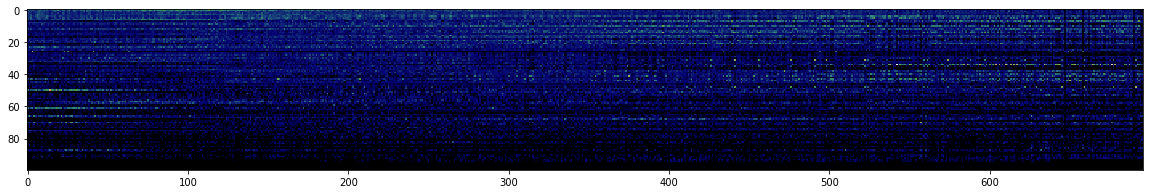

In [45]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

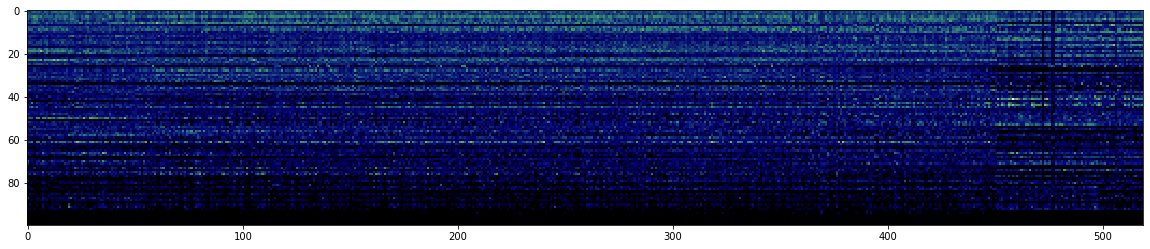

In [46]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

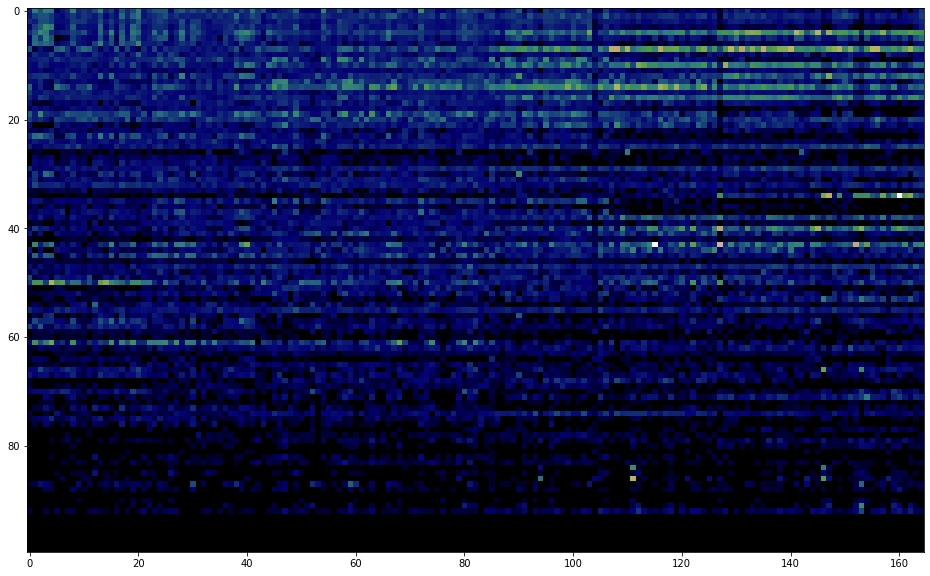

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [48]:
#syllable frequency of individual longtogeny male/females

syllable_expression_of_individual_males=[]
for n in male_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_male=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_males.append(mean_syllable_expressed_by_individual_male) 
    
syllable_expression_of_individual_females=[]
for n in female_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_female=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_females.append(mean_syllable_expressed_by_individual_female)
    
syllable_expression_of_individual_ontogeny_mice=[]
for n in ontogeny_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_ontogeny_mice=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_ontogeny_mice.append(mean_syllable_expressed_by_individual_ontogeny_mice)
    
    
#mean syllable frequency for each time point of longtogeny male/female or group for ontogeny male

male_syllable_expression_by_timepoint=[]

for n in syllable_expression_of_individual_males:
    male_syllable_expression_by_timepoint.append(np.mean(n,axis=0))

female_syllable_expression_by_timepoint=[]
for n in syllable_expression_of_individual_females:
    female_syllable_expression_by_timepoint.append(np.mean(n,axis=0))
    
ontogeny_syllable_expression_by_group=[]
for n in syllable_expression_of_individual_ontogeny_mice:
    ontogeny_syllable_expression_by_group.append(np.mean(n,axis=0))

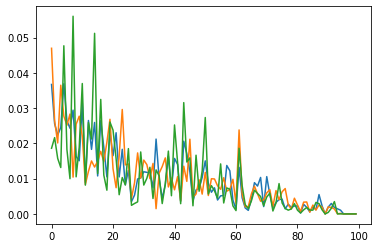

In [49]:
#across all timepoints
plt.plot(np.mean(male_syllable_expression_by_timepoint,axis=0)) #blue
plt.plot(np.mean(female_syllable_expression_by_timepoint,axis=0)) #orange
plt.plot(np.mean(ontogeny_syllable_expression_by_group,axis=0)) #green
plt.show()

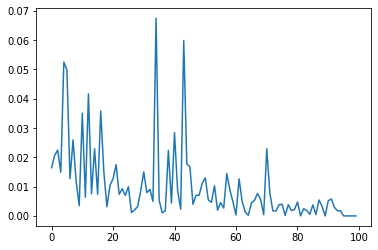

In [50]:
#at specific timepoint
t_point=42 #day 258!
plt.plot(male_syllable_expression_by_timepoint[t_point])
#plt.plot(female_syllable_expression_by_timepoint[t_point])
#plt.plot(ontogeny_syllable_expression_by_group[t_point])
plt.show()

In [51]:
#if the syllables need to be sorted by usage that can be done like so
alld = np.concatenate((np.concatenate(male_all_label_frequency_counts),np.concatenate(female_all_label_frequency_counts),np.concatenate(ontogeny_all_label_frequency_counts)))
sortbyusage_indices=np.argsort(np.mean(alld,axis=0))[::-1]

male_all_label_frequency_counts_sorted=[]
for i in range(len(male_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(male_all_label_frequency_counts[i])):
        freq_at_a_date.append(male_all_label_frequency_counts[i][ls][sortbyusage_indices])
    male_all_label_frequency_counts_sorted.append(freq_at_a_date)

female_all_label_frequency_counts_sorted=[]
for i in range(len(female_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(female_all_label_frequency_counts[i])):
        freq_at_a_date.append(female_all_label_frequency_counts[i][ls][sortbyusage_indices])
    female_all_label_frequency_counts_sorted.append(freq_at_a_date)

ontogeny_all_label_frequency_counts_sorted=[]
for i in range(len(ontogeny_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(ontogeny_all_label_frequency_counts[i])):
        freq_at_a_date.append(ontogeny_all_label_frequency_counts[i][ls][sortbyusage_indices])
    ontogeny_all_label_frequency_counts_sorted.append(freq_at_a_date)

In [52]:
#change to probabilities #also decide if using sorted or not
use_post_hoc_sort=True

if use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts_sorted)):
        for j in range(len(male_all_label_frequency_counts_sorted[n])):
            male_all_label_frequency_counts_sorted[n][j]=male_all_label_frequency_counts_sorted[n][j]/sum(male_all_label_frequency_counts_sorted[n][j])

    male_frequencies=male_all_label_frequency_counts_sorted
    
    #female longtogeny
    for n in range(len(female_all_label_frequency_counts_sorted)):
        for j in range(len(female_all_label_frequency_counts_sorted[n])):
            female_all_label_frequency_counts_sorted[n][j]=female_all_label_frequency_counts_sorted[n][j]/sum(female_all_label_frequency_counts_sorted[n][j])

    female_frequencies=female_all_label_frequency_counts_sorted
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts_sorted)):
        for j in range(len(ontogeny_all_label_frequency_counts_sorted[n])):
            ontogeny_all_label_frequency_counts_sorted[n][j]=ontogeny_all_label_frequency_counts_sorted[n][j]/sum(ontogeny_all_label_frequency_counts_sorted[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts_sorted

if not use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts)):
        for j in range(len(male_all_label_frequency_counts[n])):
            male_all_label_frequency_counts[n][j]=male_all_label_frequency_counts[n][j]/sum(male_all_label_frequency_counts[n][j])

    male_frequencies=male_all_label_frequency_counts
    #female longtogeny    
    for n in range(len(female_all_label_frequency_counts)):
        for j in range(len(female_all_label_frequency_counts[n])):
            female_all_label_frequency_counts[n][j]=female_all_label_frequency_counts[n][j]/sum(female_all_label_frequency_counts[n][j])

    female_frequencies=female_all_label_frequency_counts
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts)):
        for j in range(len(ontogeny_all_label_frequency_counts[n])):
            ontogeny_all_label_frequency_counts[n][j]=ontogeny_all_label_frequency_counts[n][j]/sum(ontogeny_all_label_frequency_counts[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts

In [53]:
len(female_frequencies)

29

In [54]:
# find how many mice in each group and figure out that noise syllable is real
for indg,group in enumerate(ontogeny_frequencies):
    print(len(group))

22
22
22
22
19
20
19
19


In [55]:
# get a structure that holds the data per individuval mouse (len=16)
age_of_mouse_at_time_zero_in_days=24
male_individuals_frequencies=[]
male_individuals_associated_dates=[]
male_individuals_days=[]

for ui in unique_individual_longtogeny_males:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(male_linear_sorted_fields)):
        if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
            a_mouse.append(male_linear_sorted_frequencies[lsf]/sum(male_linear_sorted_frequencies[lsf]))
            a_date.append(male_linear_sorted_fields[lsf][2])
            d=int_to_datetime(male_linear_sorted_fields[lsf][2])-int_to_datetime(male_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    male_individuals_frequencies.append(a_mouse)
    male_individuals_associated_dates.append(a_date)
    male_individuals_days.append(a_day)

# for females
female_individuals_frequencies=[]
female_individuals_associated_dates=[]
female_individuals_days=[]

for ui in unique_individual_longtogeny_females:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(female_linear_sorted_fields)):
        if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
            a_mouse.append(female_linear_sorted_frequencies[lsf]/sum(female_linear_sorted_frequencies[lsf]))
            a_date.append(female_linear_sorted_fields[lsf][2])
            d=int_to_datetime(female_linear_sorted_fields[lsf][2])-int_to_datetime(female_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    female_individuals_frequencies.append(a_mouse)
    female_individuals_associated_dates.append(a_date)
    female_individuals_days.append(a_day)

In [56]:
# remove bad session 258 and 103 from male_frequencies
# from frequencies
bd = male_age_labels.index("258")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "258" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("258")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)
        
bd = male_age_labels.index("103")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "103" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("103")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)

## create a dataframe for data - with mouse number, cage number, time point, all syllables data

In [57]:
# for males
male_df=pd.DataFrame()
for i in range(len(male_individuals_frequencies)):
    #male_df=pd.DataFrame()
    a=male_individuals_frequencies[i]
    b=pd.DataFrame(a)
    b['mouse'] = str(i)
    b['time'] = male_individuals_days[i]
    b['cage'] = str(int(i/4))
    male_df = male_df.append(b)

In [58]:
# for females
female_df=pd.DataFrame()
for i in range(len(female_individuals_frequencies)):
    a=female_individuals_frequencies[i]
    b=pd.DataFrame(a)
    b['mouse'] = str(i)
    b['time'] = female_individuals_days[i]
    b['cage'] = str(int(i/4))
    female_df = female_df.append(b)

In [59]:
# match males and females time points through interpolation
# arrange according to individual mice
from scipy.interpolate import interp1d
male_individuals_intr=[]
for ind, mouse in enumerate(male_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(male_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='linear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    male_individuals_intr.append(np.transpose(mouse_data))

# arrange interpolated data according to time points (much like male_frequencies)
num_time=[]
male_frequencies_intr=[]
for ind, mouse in enumerate(male_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    male_frequencies_intr.append([])
for ind, mouse in enumerate(male_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        male_frequencies_intr[indt].append(timep)
male_intr_labels = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
male_intr_labels = [int(i) for i in male_intr_labels]

#for females
female_individuals_intr=[]
for ind, mouse in enumerate(female_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(female_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='linear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    female_individuals_intr.append(np.transpose(mouse_data))

# arrange interpolated data according to time points (much like male_frequencies)
num_time=[]
female_frequencies_intr=[]
for ind, mouse in enumerate(female_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    female_frequencies_intr.append([])
for ind, mouse in enumerate(female_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        female_frequencies_intr[indt].append(timep)
female_intr_labels = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
female_intr_labels = [int(i) for i in female_intr_labels]

In [60]:
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
    
male_age_labels_int=[]
for n in male_age_labels:
    male_age_labels_int.append(int(n))
    
female_age_labels_int=[]
for n in female_age_labels:
    female_age_labels_int.append(int(n))

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [61]:
# some important variables to remember:
# frequencies: ontogeny_frequencies, male_frequencies, female_frequencies (data points X individuals X syllables)
# labels for frequencies: ontogeny_age_labels, male_age_labels, female_age_labels (len = data points)
# as individuals: male_individuals_frequencies, male_individuals_associated_dates, male_individuals_days (data points X individuals X syllables) same for female)
# identify for individuals: unique_individual_longtogeny_males (same for females)
# interpolated data frequencies: male_frequencies_intr, male_intr_labels (same for females)
# interpolated data individuals: male_individuals_intr

In [62]:
# plot/colors definitions
gep_color_mat=['limegreen', 'peru', 'silver']
from matplotlib.lines import Line2D
import matplotlib as mpl
ontogeny_age_labels = ontogeny_groups

# save figures
data_loc="/n/groups/datta/Dana/"+'ontogeny_figs_data/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

os.chdir(data_loc)

syllable usage across time points
--------------------------

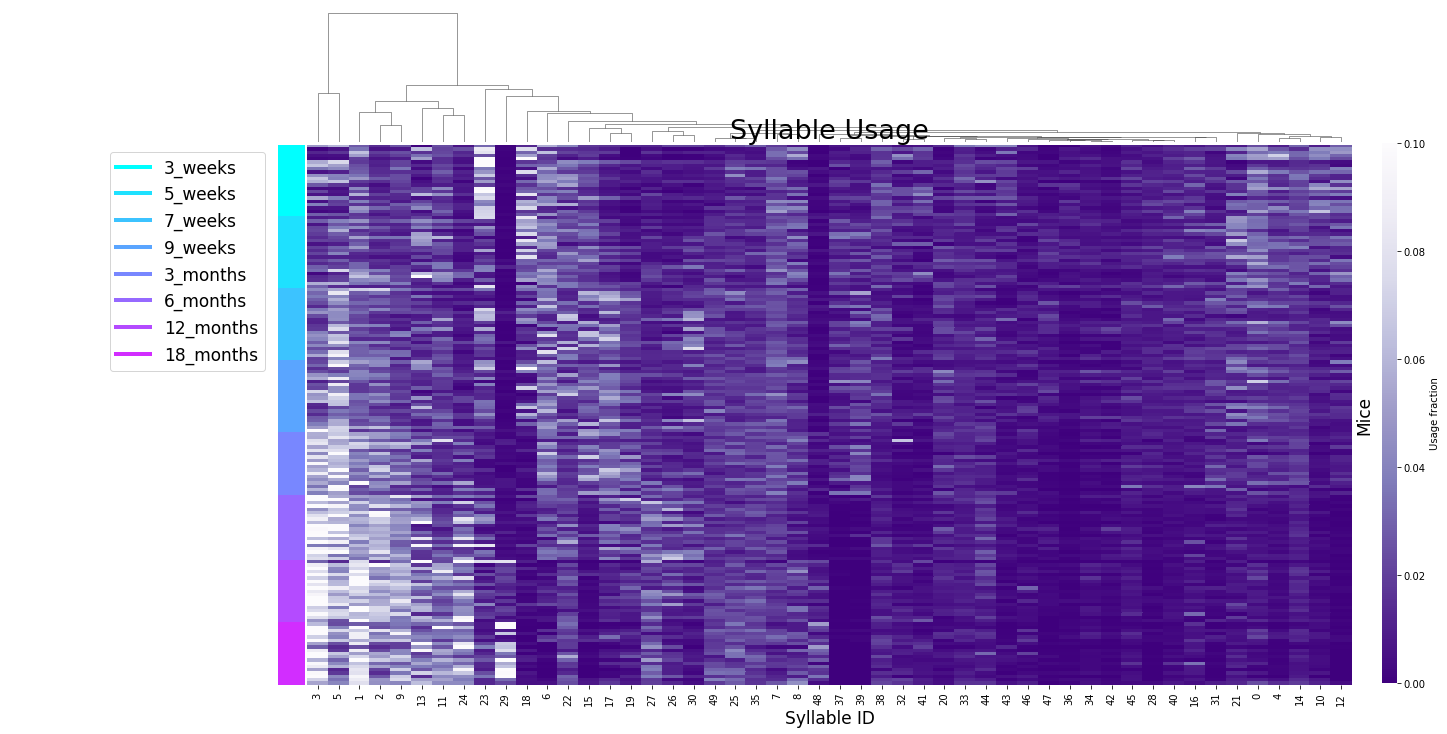

In [63]:
# plot syllable usage across time points - FLIP AXIS!!!
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'
factor=30
max_syllable=50
color_mat=[]
custom_lines=[]

# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
color_mat2=['gold','orange','sandybrown','red','mediumvioletred','mediumorchid','indigo','black']

# set the colors for the plot
for i in range(len(frequencies)):
    werwef=len(frequencies[i])
    for j in range(werwef):
        color_mat.append(cmap2(i*factor))
_,idx=np.unique(color_mat, axis=0,return_index=True)
lcol = np.array(color_mat)[np.sort(idx)]
for indc, col in enumerate(lcol):
    custom_lines.append(Line2D([0], [0], color=col, lw=4)) 
    
# plot syllable usage acoss time points
cmg=sns.clustermap(np.vstack(frequencies)[:,0:max_syllable],cmap=seqmatcolor,row_colors=color_mat, xticklabels=1,
                   colors_ratio=0.02,cbar_pos=(0.97, 0.045, 0.01, .75),
                   col_cluster=True,row_cluster=None,
                   method='average',metric='sqeuclidean',
                   cbar_kws={'label': 'Usage fraction'}, vmin=0, vmax=0.1)
cmg.fig.set_size_inches(20,10)
ax = cmg.ax_heatmap
ax.set_yticks([])
ax.set_xlabel('Syllable ID',fontsize=17)
ax.set_ylabel('Mice',fontsize=17)
ax.set_title('Syllable Usage',fontsize=27)
plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(-77, 1),loc='upper right',fontsize=17)
plt.show()

cmg.savefig(data_loc +'ontogeny_syllable_Distribution.pdf', bbox_inches='tight')

syllable usage across time points - mean across individuals
-------------

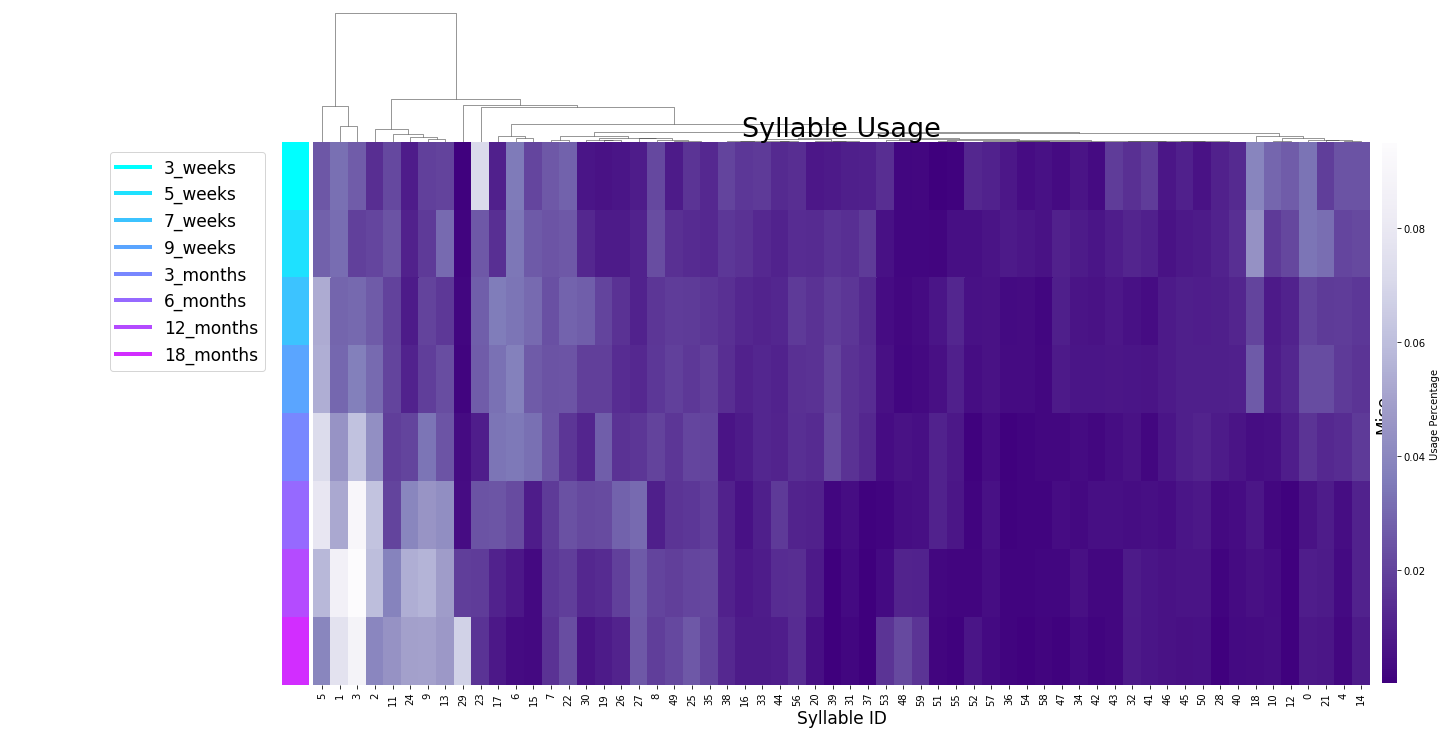

In [64]:
# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
syl_tmp=[] #hold average syllable usage per time point
factor=30
max_syllable=60
thresh=0.01 #for significance
lini=[] # incrase with age
lind=[] # decrease with age
linn=[] # has nothing to do with age

color_mat=[]
custom_lines=[]
x = np.array(range(len(frequencies)))

# set the colors for the plot
for i in range(len(frequencies)):
    color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

for tmp in frequencies: #average syllable usge across all mice per timepoint
    syl_tmp.append(np.mean(tmp,axis=0))

curr_data = np.vstack(syl_tmp)[:,0:max_syllable] 
curr_data = curr_data.T
# plot syllable usage acoss time points
cmg=sns.clustermap(np.vstack(syl_tmp)[:,0:max_syllable],cmap=seqmatcolor,row_colors=color_mat, xticklabels=1,
                   colors_ratio=0.02,cbar_pos=(0.97, 0.045, 0.01, .75),
                   col_cluster=True,row_cluster=None,
                   method='average',metric='sqeuclidean',
                   cbar_kws={'label': 'Usage Percentage'})
cmg.fig.set_size_inches(20,10)
ax = cmg.ax_heatmap
ax.set_yticks([])
ax.set_xlabel('Syllable ID',fontsize=17)
ax.set_ylabel('Mice',fontsize=17)
ax.set_title('Syllable Usage',fontsize=27)
plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(-77, 1),loc='upper right',fontsize=17)
plt.show()

/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future vers

3.837682847421938


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

3.749186198555922


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: Futur

3.4851094525930977


/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: Futur

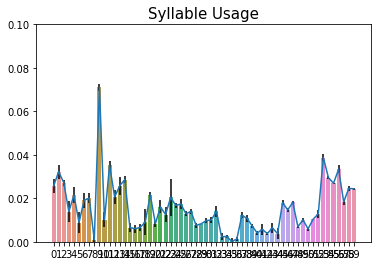

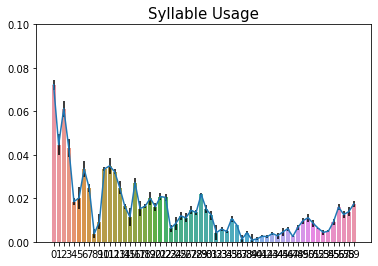

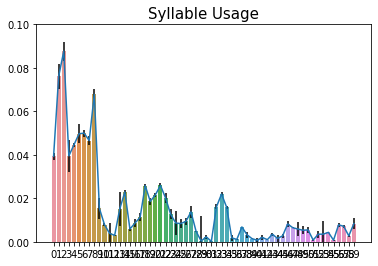

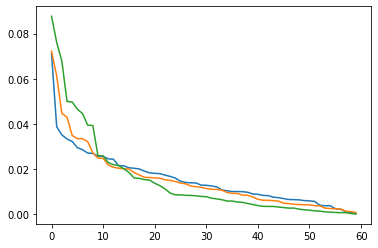

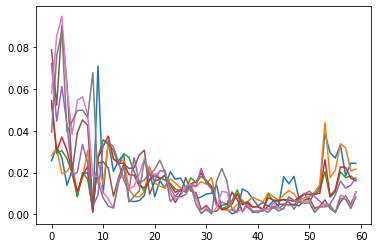

In [65]:
# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels

sm = []
se=[]
for i in frequencies:
    sm.append(np.mean(i, axis=0))
    se.append(scipy.stats.sem(i, axis=0))

s=cmg.dendrogram_col.reordered_ind #reordered columns of the matrix
freq_sorted = np.array(syl_tmp)[:,s]
wks3=(freq_sorted[0])
mn3=(freq_sorted[4])
mn18=(freq_sorted[7])
newa=[]

for i in (0,4,7):
    ydata=freq_sorted[i]
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    sns.barplot(x=np.array(range(max_syllable)), y=ydata, ci="sd")
    sns.lineplot(x=np.array(range(max_syllable)),y=ydata)
    plt.errorbar(x=np.array(range(max_syllable)),y=ydata, yerr=np.array(se[i])[0:max_syllable], fmt="none",color="k")
    ax.set_title('Syllable Usage',fontsize=15)
    plt.ylim((0,0.1))
    new=sorted(ydata,reverse=True)
    newa.append(new)
    print(scipy.stats.entropy(ydata))
    #fig.savefig(data_loc + str(i) + '_syllable_dist.pdf', bbox_inches='tight')

    
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
for i in range(len(newa)):
    ydata=newa[i]
    sns.lineplot(x=np.array(range(max_syllable)),y=ydata)

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
for i in range(len(freq_sorted)):
    ydata=freq_sorted[i]
    sns.lineplot(x=np.array(range(max_syllable)),y=ydata)


Syllable linear dependence on age
------------

In [66]:
# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
syl_tmp=[] #hold average syllable usage per time point
max_syllable=60
thresh=0.01 #for significance
lini=[] # incrase with age
lind=[] # decrease with age
linn=[] # has nothing to do with age
x = np.array(range(len(frequencies)))

for tmp in frequencies: #average syllable usge across all mice per timepoint
    syl_tmp.append(np.mean(tmp,axis=0))

for syl in range(max_syllable):
    res =linregress(x,np.array(syl_tmp)[:,syl])
    if res.pvalue < thresh:
        if res.rvalue < 0:
            lind.append(syl)
        else:
            lini.append(syl)
    else:
        linn.append(syl)
print (len(lind)," syllables decrease with age: ", lind)              
print (len(lini)," syllables increase with age: ", lini)

15  syllables decrease with age:  [0, 4, 6, 7, 10, 12, 14, 16, 18, 28, 33, 36, 40, 43, 54]
7  syllables increase with age:  [1, 3, 9, 24, 27, 35, 59]


In [67]:
from statsmodels.stats.anova import AnovaRM
age=[]
syl=[]
dfdata=[]
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
max_syllable=60
mouse=[]
for tp in range(len(frequencies)):
    curr_data=frequencies[tp]
    for i in range(18):
            age.append(age_labels[tp])
            mouse.append(i)
            dfdata.append(curr_data[i])

dfd = np.concatenate(dfdata)

for i in range(max_syllable):
    curr_syl = np.array(dfdata)[:,i]
    newdf = pd.DataFrame({'ageg': age,
                       'mou': mouse,
                       'freq': curr_syl})
    print(i)
    print(AnovaRM(data=newdf, depvar='freq', subject='mou', within=['ageg']).fit())

0
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 18.8650 7.0000 119.0000 0.0000

1
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 26.4249 7.0000 119.0000 0.0000

2
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 23.3540 7.0000 119.0000 0.0000

3
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 33.0453 7.0000 119.0000 0.0000

4
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 19.1501 7.0000 119.0000 0.0000

5
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 15.4783 7.0000 119.0000 0.0000

6
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 16.9155 7.0000 119.0000 0.0000

7
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------

               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg  6.9537 7.0000 119.0000 0.0000

50
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg  1.6319 7.0000 119.0000 0.1329

51
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 13.0293 7.0000 119.0000 0.0000

52
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg  4.5512 7.0000 119.0000 0.0002

53
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg  4.4423 7.0000 119.0000 0.0002

54
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg  8.1627 7.0000 119.0000 0.0000

55
               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
ageg 12.5659 7.0000 119.0000 0.0000

56
               Anova
     F Value Num DF  Den DF  Pr > F
------------

plot specific syllable
----------------------

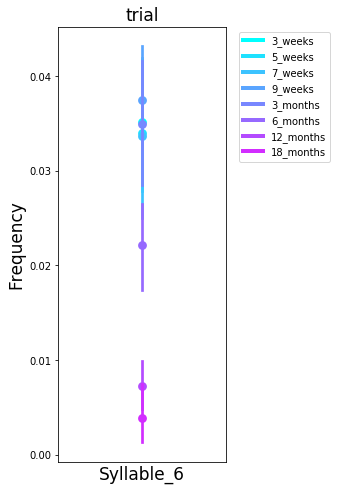

In [72]:
# plot specific syllable
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'
factor=30
max_syllable=60
color_mat=[]
custom_lines=[]
# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
s=6
s_description = "trial"
legend = True

# set the colors for the plot
for i in range(len(frequencies)):
    werwef=len(frequencies[i])
    for j in range(werwef):
        color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

# set the colors for the plot
for i in range(len(frequencies)):
    werwef=len(frequencies[i])
    for j in range(werwef):
        color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

fig, ax = plt.subplots()
fig.set_size_inches(3,8)
plt.title(s_description,fontsize=17)

for indg,group in enumerate(frequencies):
    sns.pointplot(data=np.array(group)[:,s],ax=ax,linestyles='',color=np.unique(color_mat, axis=0)[indg])
    
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks([])
#ax.set_ylim([0,.015])
#ax.set_xlim([-1,(max_syllable-.5)])
if legend:
    plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(1.05, 1),loc='upper left')

plt.xlabel('Syllable_' + str(s),fontsize=17)
plt.ylabel('Frequency',fontsize=17)
fig.patch.set_facecolor('white')
plt.show()
fig.savefig(data_loc + str(s) + '_syllable_linear_change.pdf', bbox_inches='tight')

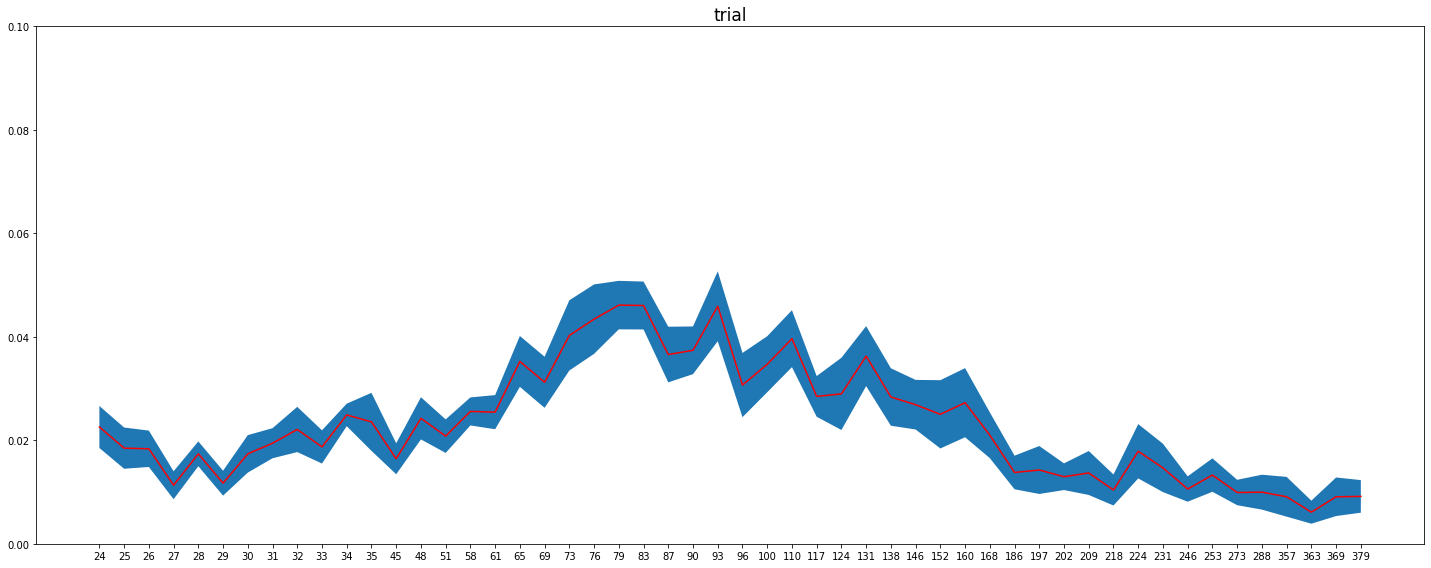

In [74]:
# plot specific syllable for longtogeny
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'
factor=30
max_syllable=60
color_mat=[]
custom_lines=[]
# variables to plot
frequencies = male_frequencies
age_labels = male_age_labels
s=6
s_description = "trial"
legend = True

# set the colors for the plot
for i in range(len(frequencies)):
    werwef=len(frequencies[i])
    for j in range(werwef):
        color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

# set the colors for the plot
for i in range(len(frequencies)):
    werwef=len(frequencies[i])
    for j in range(werwef):
        color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

sm = []
se=[]
for i in frequencies:
    sm.append(np.mean(np.array(i)[:,s], axis=0))
    se.append(scipy.stats.sem(np.array(i)[:,s], axis=0))


ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks([])

#ax.set_xlim([-1,(max_syllable-.5)])

# plot the matrix
fig, ax = plt.subplots()
fig.set_size_inches(20,8)
plt.title(s_description,fontsize=17)
#fig.patch.set_facecolor('white')
fig.tight_layout()
plt.plot(age_labels,sm, 'r-')
plt.fill_between(age_labels, np.array(sm)-np.array(se), np.array(sm)+np.array(se))
ax.set_ylim([0,.1])
plt.show()


fig.savefig(data_loc + str(s) + '_male_syllable_linear_change.pdf', bbox_inches='tight')

euclidean distance between time points
--------------------

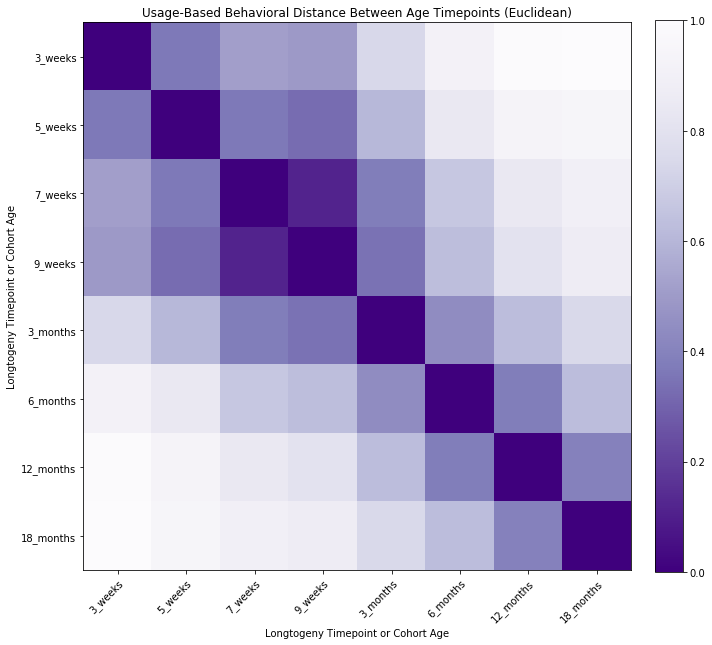

In [75]:
#calculate the euclidean distance between age groups 
# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
max_syllable=60

cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
x=0
y=0
for i in frequencies:
    for j in frequencies:
        cohort_dist[x,y]=np.sqrt(sum(np.square(np.subtract(np.mean(i,axis=0)[0:max_syllable],np.mean(j,axis=0)[0:max_syllable]))))
        # np.mean(j,axis=0) [0:max_syllable] - mean usage all syllable across mice time point j - until max syllable
        y=y+1
    y=0
    x=x+1
    
#normalize the distance between 0 and 1     
norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))    

#plot the euclidean distance matrix between ages
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im =ax.imshow(norm_dist, aspect='equal', cmap=seqmatcolor)

# We want to show all ticks...
ax.set_xticks(np.arange(len(age_labels)))
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(age_labels)
ax.set_yticklabels(age_labels)
#x and y labels
ax.set_xlabel('Longtogeny Timepoint or Cohort Age')
ax.set_ylabel('Longtogeny Timepoint or Cohort Age')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Usage-Based Behavioral Distance Between Age Timepoints (Euclidean)")
plt.colorbar(im, ax=ax, fraction=.046,pad=.04)
fig.tight_layout()
fig.patch.set_facecolor('white')
plt.show()
fig.savefig(data_loc + '_ec_distance.pdf', bbox_inches='tight')

euclidean distance between t and t+1
--------------------

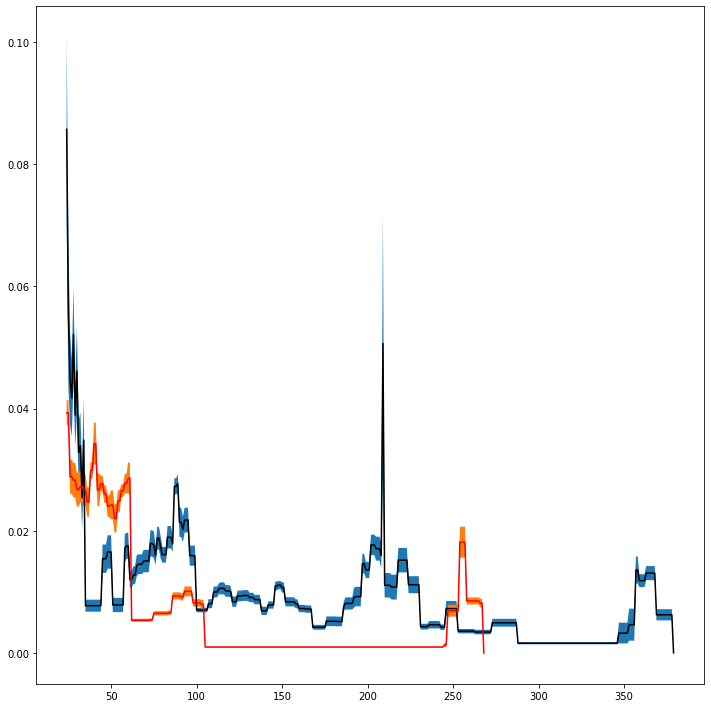

In [76]:
# calculate distance between timepoints
# variables to plot
frequencies = male_individuals_intr
mouse_labels = unique_individual_longtogeny_males
age_labels = male_intr_labels
max_syllable=60

cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'
entropy_mat=np.zeros((len(frequencies),len(frequencies[0])),dtype=float)

for ind, mouse in enumerate(frequencies):
    #getting the mouse data
    ag=0
    for ag in range(len(mouse)-1):
        entropy_mat[ind,ag]=np.sqrt(sum(np.square(np.subtract(np.array(mouse)[ag,0:max_syllable],
                                                              np.array(mouse)[ag+1,0:max_syllable]))))

#norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))    

error = scipy.stats.sem(entropy_mat)
# plot the matrix
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
fig.patch.set_facecolor('white')
fig.tight_layout()
plt.plot(age_labels, np.mean(entropy_mat,axis=0), 'k-')
plt.fill_between(age_labels, np.mean(entropy_mat,axis=0)-error, np.mean(entropy_mat,axis=0)+error)
#plt.show()        


# variables to plot females
frequencies = female_individuals_intr
mouse_labels = unique_individual_longtogeny_females
age_labels = female_intr_labels

entropy_mat=np.zeros((len(frequencies),len(frequencies[0])),dtype=float)

for ind, mouse in enumerate(frequencies):
    #getting the mouse data
    ag=0
    for ag in range(len(mouse)-1):
        entropy_mat[ind,ag]=np.sqrt(sum(np.square(np.subtract(np.array(mouse)[ag,0:max_syllable],
                                                              np.array(mouse)[ag+1,0:max_syllable]))))

#norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))    

error = scipy.stats.sem(entropy_mat)
# plot the matrix
#fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
#fig.patch.set_facecolor('white')
#fig.tight_layout()
plt.plot(age_labels, np.mean(entropy_mat,axis=0), 'r-')
plt.fill_between(age_labels, np.mean(entropy_mat,axis=0)-error, np.mean(entropy_mat,axis=0)+error)
plt.show()

euclidean distance between individuals
--------------------

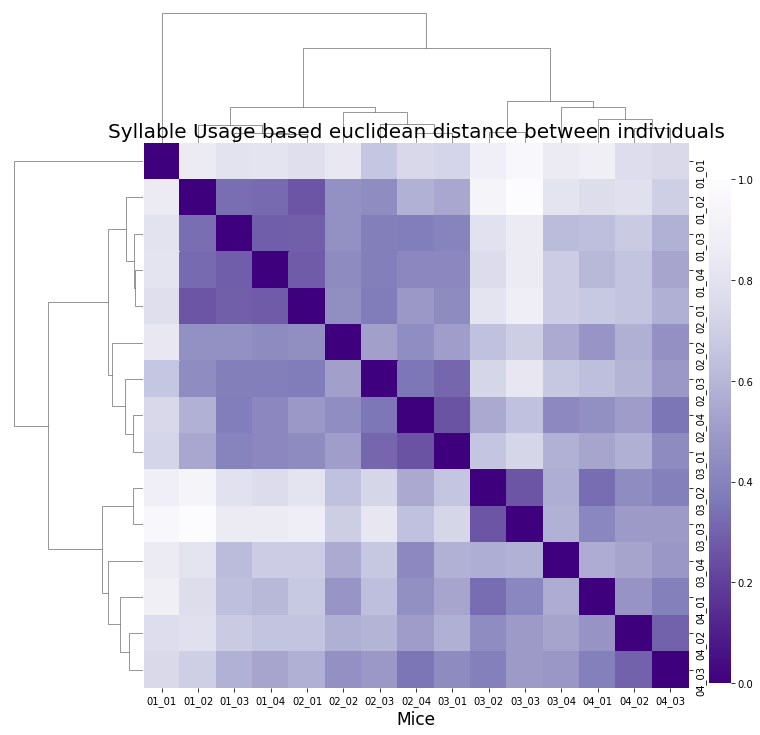

In [79]:
#calculate the euclidean distance between individuals 
# variables to plot
frequencies = male_frequencies
mouse_labels = unique_individual_longtogeny_males
age_labels = male_age_labels
max_syllable=60
datap = "363" #choose time point to explore

if datap == "all":
    frequencies = male_individuals_frequencies
    cohort_dist=np.zeros((len(mouse_labels),len(mouse_labels)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=np.sqrt(sum(np.square(np.subtract(np.mean(np.array(i)[:,0:max_syllable],axis=0),
                                                               np.mean(np.array(j)[:,0:max_syllable],axis=0)))))
            y=y+1
        y=0
        x=x+1
else:
    datap=int(age_labels.index(datap))
    frequencies = frequencies[datap]
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=np.sqrt(sum(np.square(np.subtract(np.array(i)[0:max_syllable],
                                                               np.array(j)[0:max_syllable]))))
            y=y+1
        y=0
        x=x+1
    
#normalize the distance between 0 and 1     
norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))    

#plot the euclidean distance matrix between ages
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'

cmg=sns.clustermap(np.vstack(norm_dist),cmap=seqmatcolor,xticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=True,row_cluster=True,
                   method='average',metric='sqeuclidean')

cmg.fig.set_size_inches(10,10)
ax = cmg.ax_heatmap
ax.set_xticklabels(mouse_labels)
ax.set_yticklabels(mouse_labels)
ax.set_xlabel('Mice',fontsize=17)
ax.set_ylabel('Mice',fontsize=17)
ax.set_title('Syllable Usage based euclidean distance between individuals',fontsize=20)
#plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(-77, 1),loc='upper right',fontsize=17)
plt.show()

KLD between timepoints
----------------------

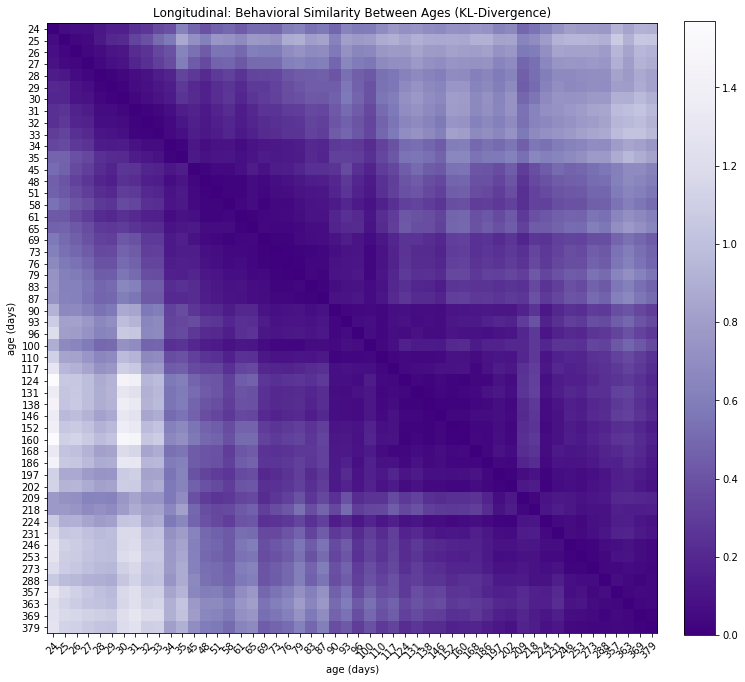

In [80]:
# calculate KLD between timepoints
# variables to plot
frequencies = male_frequencies
age_labels = male_age_labels
max_syllable=60

cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'

#getting the means and putting them in matrices
A=[]
for i in frequencies:
    A.append(np.mean(i,axis=0)[0:max_syllable])
#replace zeros with small number
for n in A:
    n[n==0]=.0000000001

#KL-Divergence Matrix (Based on Mean Syllable Usages)
entropy_mat=np.zeros((len(frequencies),len(frequencies)),dtype=float)
x=0
y=0
for i in A:
    for j in A:
        entropy_mat[x,y]=scipy.stats.entropy(pk=i,qk=j)
        # np.mean(j,axis=0) [0:max_syllable] - mean usage all syllable across mice time point j - until max syllable
        y=y+1
    y=0
    x=x+1

# plot the matrix
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
fig.patch.set_facecolor('white')
fig.tight_layout()

ax.set_title('Longitudinal: Behavioral Similarity Between Ages (KL-Divergence)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(age_labels)))
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(age_labels)
ax.set_yticklabels(age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
wefww=ax.imshow(entropy_mat,cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
ax.set_ylabel('age (days)')
ax.set_xlabel('age (days)')
plt.show()
fig.savefig(data_loc + 'male_KLD_distance.pdf', bbox_inches='tight')

KLD between individuals
------------


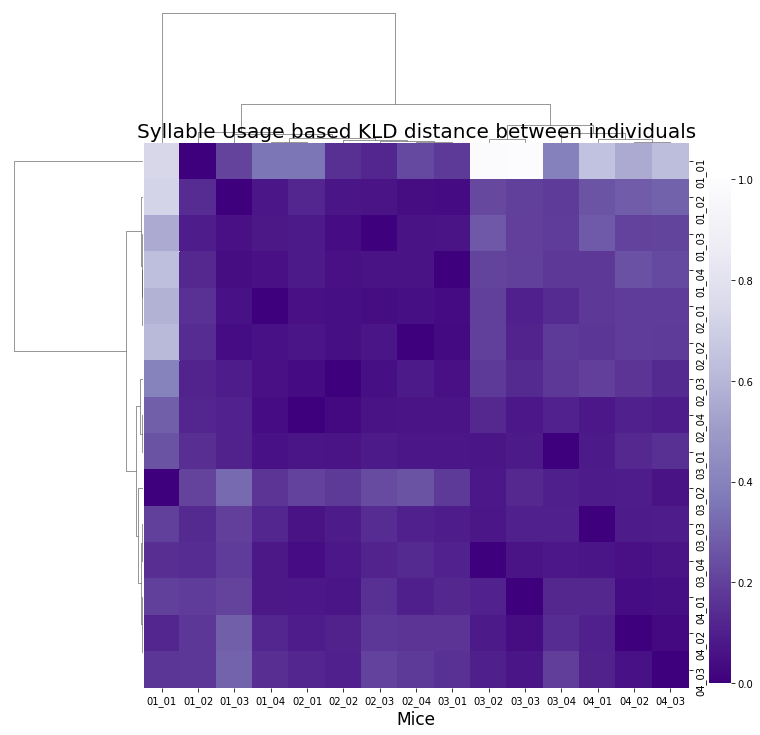

In [81]:
#calculate the KLD between individuals
# variables to plot
frequencies = male_frequencies
mouse_labels = unique_individual_longtogeny_males
age_labels = male_age_labels
max_syllable=60
datap = "363" #choose time point to explore

if datap == "all":
    frequencies = male_individuals_frequencies
    cohort_dist=np.zeros((len(mouse_labels),len(mouse_labels)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            for n in i: #replaced 0 values
                n[n==0]=.0000000001
            for m in j:
                m[m==0]=.0000000001            
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.mean(np.array(i)[:,0:max_syllable],axis=0)
                                                 ,qk=np.mean(np.array(j)[:,0:max_syllable],axis=0))
            y=y+1
        y=0
        x=x+1
else:
    datap=int(age_labels.index(datap))
    frequencies = frequencies[datap]
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i)[0:max_syllable], qk=np.array(j)[0:max_syllable])
            y=y+1
        y=0
        x=x+1
    
#normalize the distance between 0 and 1     
norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))    

#plot the euclidean distance matrix between ages
cmap2 = mpl.cm.cool
seqmatcolor='Purples_r'

cmg=sns.clustermap(np.vstack(norm_dist),cmap=seqmatcolor,xticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=True,row_cluster=True,
                   method='average',metric='sqeuclidean')

cmg.fig.set_size_inches(10,10)
ax = cmg.ax_heatmap
ax.set_xticklabels(mouse_labels)
ax.set_yticklabels(mouse_labels)
ax.set_xlabel('Mice',fontsize=17)
ax.set_ylabel('Mice',fontsize=17)
ax.set_title('Syllable Usage based KLD distance between individuals',fontsize=20)
#plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(-77, 1),loc='upper right',fontsize=17)
plt.show()

KLD as scatter plot
-------

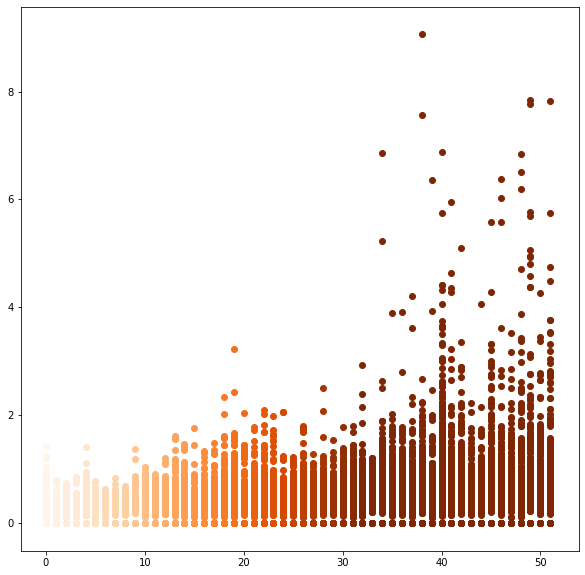

In [88]:
#calculate the KLD between individuals and plot as scatter plot
# plot specific syllable
cmap2 = mpl.cm.Oranges
seqmatcolor='Purples_r'
factor=8
max_syllable=60
color_mat=[]
custom_lines=[]

# variables to plot
frequencies = male_frequencies
age_labels = male_age_labels
time_point=[]
time_point_error=[]
time_point_all=[]

# set the colors for the plot
for i in range(len(frequencies)):
    color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

# plotting it as a scatter plot by age
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

for datap in range(len(age_labels)):
    curr_frequencies = frequencies[datap]
    cohort_dist=np.zeros((len(curr_frequencies),len(curr_frequencies)),dtype=float)
    x=0
    y=0
    for i in curr_frequencies:
        for j in curr_frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i)[0:max_syllable], qk=np.array(j)[0:max_syllable])
            y=y+1
        y=0
        x=x+1
    plt.scatter(x=np.ones(len(np.concatenate(cohort_dist)))*datap,y=np.concatenate(cohort_dist),color=color_mat[datap])
    time_point.append(np.mean(cohort_dist))
    time_point_error.append(scipy.stats.sem(np.concatenate(cohort_dist)))
    time_point_all.append(np.concatenate(cohort_dist))



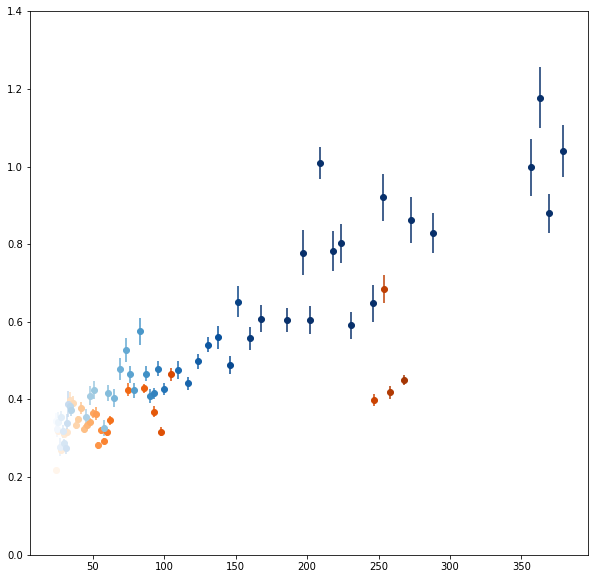

In [98]:
#calculate the KLD between individuals and plot as scatter plot
# plot specific syllable
cmap2 = mpl.cm.Oranges
seqmatcolor='Purples_r'
factor=8
max_syllable=60
color_mat=[]
custom_lines=[]

# variables to plot
frequencies = female_frequencies
age_labels = female_age_labels
time_point=[]
time_point_error=[]
time_point_all=[]

# set the colors for the plot
for i in range(len(frequencies)):
    color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

# plotting it as a scatter plot by age
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

for datap in range(len(age_labels)):
    curr_frequencies = frequencies[datap]
    cohort_dist=np.zeros((len(curr_frequencies),len(curr_frequencies)),dtype=float)
    x=0
    y=0
    for i in curr_frequencies:
        for j in curr_frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i)[0:max_syllable], qk=np.array(j)[0:max_syllable])
            y=y+1
        y=0
        x=x+1
    #plt.scatter(x=np.ones(len(np.concatenate(cohort_dist)))*datap,y=np.concatenate(cohort_dist),color=color_mat[datap])
    time_point.append(np.mean(cohort_dist))
    time_point_error.append(scipy.stats.sem(np.concatenate(cohort_dist)))
    time_point_all.append(np.concatenate(cohort_dist))

for ind, d in enumerate(female_age_labels_int):
    plt.errorbar(d, time_point[ind], yerr=time_point_error[ind], fmt="o",color=color_mat[ind])


###################### for males!!!!!!!!!
#calculate the KLD between individuals and plot as scatter plot
# plot specific syllable
cmap2 = mpl.cm.Blues
seqmatcolor='Purples_r'
factor=7
max_syllable=60
color_mat=[]
custom_lines=[]

# variables to plot
frequencies = male_frequencies
age_labels = male_age_labels
time_point=[]
time_point_error=[]
time_point_all=[]

# set the colors for the plot
for i in range(len(frequencies)):
    color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

for datap in range(len(age_labels)):
    curr_frequencies = frequencies[datap]
    cohort_dist=np.zeros((len(curr_frequencies),len(curr_frequencies)),dtype=float)
    x=0
    y=0
    for i in curr_frequencies:
        for j in curr_frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i)[0:max_syllable], qk=np.array(j)[0:max_syllable])
            y=y+1
        y=0
        x=x+1
    #plt.scatter(x=np.ones(len(np.concatenate(cohort_dist)))*datap,y=np.concatenate(cohort_dist),color=color_mat[datap])
    time_point.append(np.mean(cohort_dist))
    time_point_error.append(scipy.stats.sem(np.concatenate(cohort_dist)))
    time_point_all.append(np.concatenate(cohort_dist))
    
fig.set_size_inches(10,10)
ax.set_ylim([0,1.4])    
for ind, d in enumerate(male_age_labels_int):
    plt.errorbar(d, time_point[ind], yerr=time_point_error[ind], fmt="o",color=color_mat[ind])
plt.show()
fig.savefig(data_loc + 'female_male_KLD_individuals2.pdf', bbox_inches='tight')


PCA projection of individual mice by age
------------------

In [ ]:
#calculate the KLD between individuals and plot as scatter plot
# plot specific syllable
cmap2 = mpl.cm.Oranges
seqmatcolor='Purples_r'
factor=20
max_syllable=100
color_mat=[]
custom_lines=[]

# variables to plot

frequencies = female_frequencies
age_labels = female_age_labels
max_syllable=60

# set the colors for the plot
for i in range(len(frequencies)):
    color_mat.append(cmap2(i*factor))
for indc, col in enumerate(np.unique(color_mat, axis=0)):
    custom_lines.append(Line2D([0], [0], color=col, lw=4))

# calculate PCA
pcs,evecs,evals=pca_on_np_array(np.concatenate(frequencies,axis=0))

# get first 3 pcs
pc1=[]
pc2=[]
pc3=[]
for n in pcs:
    pc1.append(n[0])
    pc2.append(n[1])
    pc3.append(n[2])   

freq_blocks=[]
for n in frequencies: #how many mice in each age group
    freq_blocks.append(len(n))

fig, ax = plt.subplots()
fig.set_size_inches(10,10)  
    
# plot
pos=0  
for i in range(len(freq_blocks)):
    sns.scatterplot(x=pc1[pos:pos+freq_blocks[i]-1],y=pc2[pos:pos+freq_blocks[i]-1],color=color_mat[i],s=50,alpha=1)   
    pos=pos+freq_blocks[i]

#plt.legend(handles=custom_lines,labels=age_labels)
plt.title('Syllable Usage Principle Component Analysis',fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')

fig.savefig(data_loc + 'pca_ofemale.pdf', bbox_inches='tight')

In [ ]:
cmap2 = mpl.cm.Oranges
fig, ax = plt.subplots()
fig.set_size_inches(10,10)  
wefww=ax.imshow(color_mat,cmap=cmap2)
plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
fig.savefig(data_loc + 'pca_female_colorbar.pdf', bbox_inches='tight')

age decoder
------------

In [ ]:
def wrapping_slice(lst, *args):
    return [lst[i%len(lst)] for i in range(*args)]

def return_confusion(predictions):
    cnf_mat=np.zeros((len(predictions),len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            cnf_mat[i,j]=np.count_nonzero(predictions[i]==j) / len(predictions[i])
    return cnf_mat

# variables to plot
frequencies = ontogeny_frequencies
age_labels = ontogeny_age_labels
max_syllable=60

# decoder
data=np.concatenate(frequencies,axis=0)[:,0:max_syllable] # all data concatenated

# all age labels concatenated
age_num=[]
for n in frequencies: #how many mice in each age group
    age_num.append(len(n))

age_tags=[]
for indx, num in enumerate(age_num):
    for i in range(num):
        age_tags.append(age_labels[indx])

for indx, mouse in enumerate(data):
    x=data.copy()
    y=age_tags.copy()
    m=x.pop(indx)
    l=age_tags.pop(indx)
    

In [ ]:

#ACTUAL DECODEDRRRRR
min_syllable=0
max_syllable=40

n_training_mice= .85 #percent of mice to be used for training

int_n_training_mice=int(n_training_mice*16) #* number of mice
rotations=16 #number of mice
logmodels=[]
ldamodels=[]
for r in range(rotations):
    X=[]
    for n in frequencies:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        X.append(np.array(rotated_slice)[:,min_syllable:max_syllable])
    X=np.vstack(X)
    y=[]
    i=0
    for n in frequencies:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        for j in range(len(np.array(rotated_slice))):
            y.append(i)
        i=i+1
    y=np.array(y)
    
    logmodel = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
    logmodel.fit(X, y)
    logmodels.append(logmodel)
    
    ldamodel = LinearDiscriminantAnalysis(solver='svd')
    ldamodel.fit(X, y)
    ldamodels.append(ldamodel)
    
    
lda_regress_predictions=[]
log_regress_predictions=[]
for i in range(16): #number of mice
    lda_regress_predictions.append([0])
    log_regress_predictions.append([0])

for r in range(rotations):
    
    Xnew=[]
    for n in frequencies:
        rotated_slice=np.array(wrapping_slice(n,r+int_n_training_mice,r+int_n_training_mice+1))[0][min_syllable:max_syllable]
        Xnew.append(rotated_slice)
        # make a prediction
        
    ynew = ldamodels[r].predict(Xnew)
    lda_regress_predictions[r].append(ynew)
   
    ynew = logmodels[r].predict(Xnew)
    log_regress_predictions[r].append(ynew)
    
for i in range(16):
    lda_regress_predictions[i].remove(0)
    log_regress_predictions[i].remove(0)
    
lda_regress_predictions=np.concatenate(lda_regress_predictions).T
log_regress_predictions=np.concatenate(log_regress_predictions).T

Rockwells age decoder
------------


Stability analysis
-------------

In [ ]:
male_individuals_frequencies=[]
male_individuals_associated_dates=[]

for ui in unique_individual_longtogeny_males:
    
    
    a_mouse=[]
    a_date=[]
    #remove mouse three from each cage since half the sessions are missing...
    if ui[3:5]!='03':
        for lsf in range(len(male_linear_sorted_fields)):
            if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
                a_mouse.append(male_linear_sorted_frequencies[lsf])
                a_date.append(male_linear_sorted_fields[lsf][2])
        male_individuals_frequencies.append(a_mouse)
        male_individuals_associated_dates.append(a_date)
    
male_individuals_frequencies_withnas=male_individuals_frequencies[:]
for n in range(len(male_individuals_frequencies_withnas)):
    for m in range(len(male_individuals_frequencies_withnas[n])):
        if sum(male_individuals_frequencies_withnas[n][m])==0:
            male_individuals_frequencies_withnas[n][m]=male_individuals_frequencies_withnas[n][m]*np.nan
            #print(m)
            
female_individuals_frequencies=[]
female_individuals_associated_dates=[]

for ui in unique_individual_longtogeny_females:
    
    
    a_mouse=[]
    a_date=[]
    #remove mouse three from each cage since half the sessions are missing...
    if ui[3:5]!='03':   
        for lsf in range(len(female_linear_sorted_fields)):
            if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
                a_mouse.append(female_linear_sorted_frequencies[lsf])
                a_date.append(female_linear_sorted_fields[lsf][2])
        female_individuals_frequencies.append(a_mouse)
        female_individuals_associated_dates.append(a_date)
    
female_individuals_frequencies_withnas=female_individuals_frequencies[:]
for n in range(len(female_individuals_frequencies_withnas)):
    for m in range(len(female_individuals_frequencies_withnas[n])):
        if sum(female_individuals_frequencies_withnas[n][m])==0:
            female_individuals_frequencies_withnas[n][m]=female_individuals_frequencies_withnas[n][m]*np.nan
            #print(m)

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(20,4)

#RUNNING STDEV

window=4

#males
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(male_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas[indv])-window):
        rd=np.nanstd(np.array(male_individuals_frequencies_withnas)[indv][t:t+window])
        d1=male_age_labels_int[t]
        d2=male_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in male_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(male_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='blue')
    all_rds.append(running_dist)
    
#females
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(female_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas[indv])-window):
        rd=np.nanstd(np.array(female_individuals_frequencies_withnas)[indv][t:t+window])
        d1=female_age_labels_int[t]
        d2=female_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in female_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(female_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='orange')
    all_rds.append(running_dist)


#RUNNING KLD

window=4

#males
all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(male_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(male_individuals_frequencies_withnas)[indv][t:t+window]:
            for second_data in np.array(male_individuals_frequencies_withnas)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=male_age_labels_int[t]
        d2=male_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in male_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(male_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='blue')
    all_rds.append(running_dist)


#females
all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(female_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(female_individuals_frequencies_withnas)[indv][t:t+window]:
            for second_data in np.array(female_individuals_frequencies_withnas)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=female_age_labels_int[t]
        d2=female_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in female_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(female_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='orange')
    all_rds.append(running_dist)
    
ax[0].set(xlabel='age (days)')
ax[1].set(xlabel='age (days)')
ax[0].set(title='Behavioral Instability (Running STDEV)')
ax[1].set(title='Behavioral Instability (Running KLD)')
ax[0].set_xlim([24,250])
ax[1].set_xlim([24,250])
fig.subplots_adjust(wspace=.2, hspace=0)

plt.show()
fig.patch.set_facecolor('white')
fig.savefig(data_loc + ' Behavioral Stability (Individuals and Means)2.pdf', bbox_inches='tight')
fig.savefig(data_loc + ' Behavioral Stability (Individuals and Means)2.png', bbox_inches='tight')

In [ ]:
#KL-Divergence Matrix (Based on Mean Syllable Usages)
entropyblabla=np.zeros((len(age_labels),len(age_labels)))
for i in range(len(age_labels)):
    for j in range(len(age_labels)):
        entropyblabla[i,j]=scipy.stats.entropy(pk=A[i][0:max_syllable],qk=A[j][0:max_syllable]) 
        
        
fig,ax=plt.subplots()
fig.set_size_inches(20,20)
fig.patch.set_facecolor('white')
fig.tight_layout()


ax.set_title('Longitudinal: Behavioral Similarity Between Ages (KL-Divergence)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(age_labels)))
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(age_labels)
ax.set_yticklabels(age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

In [ ]:
#INDIVUAL DECODEABILITY MALES

# creating graph space for two graphs
fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
fig.patch.set_facecolor('white')
fig.tight_layout()

# plot1 graph for normal axes
ebbb_f=entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)][0]
ebbb_f=entropyblabla[0:46,0:46][0]

#plot1.plot(np.array(male_age_labels_int),np.nancumsum(ebbb_f)/sum(ebbb_f),color='blue')
plot1.plot(np.array(male_age_labels_int[0:46]),np.nancumsum(ebbb_f)/sum(ebbb_f),color='blue')
plot1.set_title("Forward Decoding of Individual Males")
plot1.set_ylabel('Relative Decodeability')


# plot2 graph for inverted axes
ebbb_r=entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)][len(male_age_labels_int)-1]
ebbb_r=entropyblabla[0:46,0:46][46-1]


#plot2.plot(np.array(male_age_labels_int),np.nancumsum(ebbb_r)/sum(ebbb_r),color='blue')
plot2.plot(np.array(male_age_labels_int[0:46]),np.nancumsum(ebbb_r)/sum(ebbb_r),color='blue')
plot2.set_title("Backwards Decoding of Individual Males")
plot2.invert_xaxis()
plot2.invert_yaxis()
plot2.set_yticks([])
# display the graph
plt.show()

fig.savefig(strain + ' Male Individual Decodeability F and R.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Individual Decodeability F and R.png', bbox_inches='tight')

In [ ]:
#INDIVUAL DECODEABILITY MALES

# creating graph space for two graphs
fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
fig.patch.set_facecolor('white')
fig.tight_layout()

# plot1 graph for normal axes
ebbb_f=entropyblabla[len(male_age_labels_int):len(entropyblabla)-8,len(male_age_labels_int):len(entropyblabla)-8][0]

plot1.plot(np.array(female_age_labels_int),np.nancumsum(ebbb_f)/sum(ebbb_f),color='orange')
plot1.set_title("Forward Decoding of Individual Females")
plot1.set_ylabel('Relative Decodeability')
# plot2 graph for inverted axes
ebbb_r=entropyblabla[len(male_age_labels_int):len(entropyblabla)-8,len(male_age_labels_int):len(entropyblabla)-8][len(female_age_labels_int)-1]
plot2.plot(np.array(female_age_labels_int),np.nancumsum(ebbb_r)/sum(ebbb_r),color='orange')
plot2.set_title("Backwards Decoding of Individual Females")
plot2.invert_xaxis()
plot2.invert_yaxis()
plot2.set_yticks([])
# display the graph
plt.show()
fig.savefig(strain + ' Female Individual Decodeability F and R.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Individual Decodeability F and R.png', bbox_inches='tight')

In [ ]:
def wrapping_slice(lst, *args):
    return [lst[i%len(lst)] for i in range(*args)]

def return_confusion(predictions):
    cnf_mat=np.zeros((len(predictions),len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            cnf_mat[i,j]=np.count_nonzero(predictions[i]==j) / len(predictions[i])
    return cnf_mat

In [ ]:
n_training_mice = .75 #use 80% of mice to train

int_n_training_mice=int(n_training_mice*16) #* number of mice
rotations=16 #number of mice
male_logmodels=[]
male_ldamodels=[]
for r in range(rotations):
    X=[]
    for n in male_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        X.append(np.array(rotated_slice)[:,0:max_syllable])
    X=np.vstack(X)
    y=[]
    i=0
    for n in male_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        for j in range(len(np.array(rotated_slice))):
            y.append(i)
        i=i+1
    y=np.array(y)
    
    male_logmodel = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
    male_logmodel.fit(X, y)
    male_logmodels.append(male_logmodel)
    
    male_ldamodel = LinearDiscriminantAnalysis(solver='svd')
    male_ldamodel.fit(X, y)
    male_ldamodels.append(male_ldamodel)
    
    
    
    
male_lda_regress_predictions=[]
male_log_regress_predictions=[]
for i in range(16): #number of mice
    male_lda_regress_predictions.append([0])
    male_log_regress_predictions.append([0])

for r in range(rotations):
    
    Xnew=[]
    for n in male_all_label_frequency_counts:
        rotated_slice=np.array(wrapping_slice(n,r+int_n_training_mice,r+int_n_training_mice+1))[0][0:max_syllable]
        Xnew.append(rotated_slice)
        # make a prediction
        
    ynew = male_ldamodels[r].predict(Xnew)
    male_lda_regress_predictions[r].append(ynew)
   
    ynew = male_logmodels[r].predict(Xnew)
    male_log_regress_predictions[r].append(ynew)
    
for i in range(16):
    male_lda_regress_predictions[i].remove(0)
    male_log_regress_predictions[i].remove(0)
    
male_lda_regress_predictions=np.concatenate(male_lda_regress_predictions).T
male_log_regress_predictions=np.concatenate(male_log_regress_predictions).T

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
fig.patch.set_facecolor('white')
fig.tight_layout()


ax.set_title('Longtitudinal: Logistic Regression Confusion Matrix (Predicting Male Age From Behavior)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels)))
ax.set_yticks(np.arange(len(male_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
ax.set_yticklabels(male_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('age input')
ax.set_xlabel('age output')

wefww=ax.imshow(return_confusion(male_log_regress_predictions),cmap='Greys', vmin=0, vmax=0.7)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)


plt.show()

fig.savefig(strain + ' Male Logistic Regression Confusion Matrix.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Logistic Regression Confusion Matrix.png', bbox_inches='tight')